# Jewellery Price Optimization with ML: Pricing Data to Refine Pricing Strategies

# 1. Business Understanding
Inconsistent pricing strategies across regions and product lines.
Lack of a data-driven approach to predict demand elasticity.
High competition necessitating quick responses to market trend


# Imprt Libraires

In [1]:
# Essential Configuration
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'svg'}

# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


# Scikit-learn Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Display Settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Adjust the display width to accommodate all columns

# Seaborn Default Settings
sns.set(
    {
        "figure.figsize": (8, 6)
    },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)

# mlflow
import mlflow
import mlflow.sklearn


In [3]:
from phik import phik_matrix
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import  RandomForestRegressor
import xgboost as xgb
import category_encoders as ce

# 1.0 Data Understanding and Exploratory Data Analysis (EDA)
# 1.1 Load Dataset and Add Column Headers


In [4]:
# Load dataset
df = pd.read_csv('Jewelry_Dataset.csv')

# Add column headers
df.columns = [
    "Order_datetime",
    "Order_ID",
    "Product_ID",
    "SKU_Quantity",
    "Category_ID",
    "Category",
    "Brand_ID",
    "Price_USD",
    "User_ID",
    "Target_Gender",
    "Main_Color",
    "Main_Metal",
    "Main_Gem"
]

# Display first five rows
df.head()


Order_datetime             Order_ID           Product_ID  \
0  2018-12-01 17:38:31 UTC  1924899396621697920  1806829193678291446   
1  2018-12-02 13:53:42 UTC  1925511016616034733  1842214461889315556   
2  2018-12-02 17:44:02 UTC  1925626951238681511  1835566849434059453   
3  2018-12-02 21:30:19 UTC  1925740842841014667  1873936840742928865   
4  2018-12-02 22:09:34 UTC  1925760595336888995  1835566854827934449   

   SKU_Quantity   Category_ID          Category  Brand_ID  Price_USD  \
0             1  1.806829e+18               NaN       NaN     212.14   
1             1  1.806829e+18   jewelry.pendant       1.0      54.66   
2             1  1.806829e+18   jewelry.pendant       0.0      88.90   
3             1  1.806829e+18  jewelry.necklace       0.0     417.67   
4             1  1.806829e+18   jewelry.earring       1.0     102.27   

        User_ID Target_Gender Main_Color Main_Metal  Main_Gem  
0  1.515916e+18           NaN     yellow       gold       NaN  
1  1.515916e+18             f      white       gold  sapphire  
2  1.515916e+18             f        red       gold   diamond  
3  1.515916e+18           NaN        red       gold  amethyst  
4  1.515916e+18           NaN        red       gold       NaN

# Data Description

The features contained in the dataset are:
1. Order datetime: The time at which the order was placed.
2. Order ID: Identifiers for the different orders placed.
3. Purchased product ID: Identifiers for the different product ordered for.
4. Quantity of SKU in the order: Quantity of jewelry pieces ordered for.
5. Category ID: Identifier for the jewelry category.
6. Category alias: Name of jewelry category e.g. earring.
7. Brand ID: Identifier for jeweler brand
8. Price in USD: Jewelry price in US Dollars
9. User ID: Identifier for user/customer
10. Product gender (for male/female) (Target gender for jewelry piece)
11. Main Color: Overall color of jewelry piece
12. Main metal: Main metal used for mounting
13. Main gem: Main gem mounted on jewelry piece


# 1.2 Dataset Summary

In [8]:
# Check dataset shape
print(f"The Dataset shape is: {df.shape}")

print("----------------------------------")

# Dataset info
df.info()


The Dataset shape is: (95910, 13)
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95910 entries, 0 to 95909
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order_datetime  95910 non-null  object 
 1   Order_ID        95910 non-null  int64  
 2   Product_ID      95910 non-null  int64  
 3   SKU_Quantity    95910 non-null  int64  
 4   Category_ID     90558 non-null  float64
 5   Category        85977 non-null  object 
 6   Brand_ID        91125 non-null  float64
 7   Price_USD       90558 non-null  float64
 8   User_ID         90558 non-null  float64
 9   Target_Gender   47743 non-null  object 
 10  Main_Color      88250 non-null  object 
 11  Main_Metal      90448 non-null  object 
 12  Main_Gem        61852 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 9.5+ MB


In [9]:
# Check for missing values and percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)

# Combine the results into a single DataFrame for better readability
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Value Description:")
print(missing_summary)


Missing Value Description:
                Missing Values  Percentage
Order_datetime               0    0.000000
Order_ID                     0    0.000000
Product_ID                   0    0.000000
SKU_Quantity                 0    0.000000
Category_ID               5352    5.580231
Category                  9933   10.356584
Brand_ID                  4785    4.989052
Price_USD                 5352    5.580231
User_ID                   5352    5.580231
Target_Gender            48167   50.221041
Main_Color                7660    7.986654
Main_Metal                5462    5.694922
Main_Gem                 34058   35.510374


In [10]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

print("---------------------------------------")

# Check unique values
print(f"Unique values:\n{df.nunique()}")


The dataset contains 2589 duplicate rows that need to be removed.
---------------------------------------
Unique values:
Order_datetime    74504
Order_ID          74759
Product_ID         9613
SKU_Quantity          1
Category_ID          25
Category            218
Brand_ID           2537
Price_USD          3166
User_ID           31079
Target_Gender         2
Main_Color            5
Main_Metal            3
Main_Gem             30
dtype: int64


In [22]:
# Create a DataFrame with counts and percentages -Target Gender Distribution
gender_distribution = pd.DataFrame({
    'Count': df['Target_Gender'].value_counts(),
    'Percentage (%)': df['Target_Gender'].value_counts(normalize=True) * 100
}).reset_index()

# Rename columns for clarity
gender_distribution.columns = ['Target Gender', 'Count', 'Percentage (%)']

# Display the DataFrame
gender_distribution


Target Gender  Count  Percentage (%)
0             f  47379       99.237585
1             m    364        0.762415

In [11]:
# Check unique values for categorical features
print("Unique Values in Categorical Features:")
print("---------------------------------------")
print(f"1. Target Gender: {df['Target_Gender'].unique()}")
print("---------------------------------------")
print(f"2. Main Color: {df['Main_Color'].unique()}")
print("---------------------------------------")
print(f"3. Main Metal: {df['Main_Metal'].unique()}")
print("---------------------------------------")
print(f"4. Main Gem: {df['Main_Gem'].unique()}")
print("---------------------------------------")
print(f"5. Category: {df['Category'].unique()}")


Unique Values in Categorical Features:
---------------------------------------
1. Target Gender: [nan 'f' 'm']
---------------------------------------
2. Main Color: ['yellow' 'white' 'red' nan 'unknown-color' 'black']
---------------------------------------
3. Main Metal: ['gold' 'silver' nan 'platinum']
---------------------------------------
4. Main Gem: [nan 'sapphire' 'diamond' 'amethyst' 'fianit' 'pearl' 'quartz' 'topaz'
 'garnet' 'quartz_smoky' 'ruby' 'agate' 'mix' 'citrine' 'emerald' 'amber'
 'chrysolite' 'chrysoprase' 'nanocrystal' 'turquoise' 'sitall'
 'corundum_synthetic' 'coral' 'onyx' 'nacre' 'spinel' 'tourmaline'
 'emerald_geothermal' 'garnet_synthetic' 'rhodolite' 'sapphire_geothermal']
---------------------------------------
5. Category: [nan 'jewelry.pendant' 'jewelry.necklace' 'jewelry.earring' 'jewelry.ring'
 'jewelry.brooch' 'jewelry.bracelet' 'electronics.clocks'
 'jewelry.souvenir' '230.12' '202.36' '1098.03' '321.78' '1128.62' '81.27'
 '34.25' '582.16' '227.37' '

# 1.3 Statistical Analysis

In [12]:
# Summary statistics
df.describe(include='all').round(2)

Order_datetime      Order_ID    Product_ID  SKU_Quantity  \
count                     95910  9.591000e+04  9.591000e+04       95910.0   
unique                    74504           NaN           NaN           NaN   
top     2020-10-17 12:58:28 UTC           NaN           NaN           NaN   
freq                         26           NaN           NaN           NaN   
mean                        NaN  2.485191e+18  1.815970e+18           1.0   
std                         NaN  1.934750e+17  2.136814e+17           0.0   
min                         NaN  1.924899e+18  1.313551e+18           1.0   
25%                         NaN  2.379732e+18  1.515966e+18           1.0   
50%                         NaN  2.524282e+18  1.956664e+18           1.0   
75%                         NaN  2.644347e+18  1.956664e+18           1.0   
max                         NaN  2.719022e+18  2.541962e+18           1.0   

         Category_ID         Category      Brand_ID  Price_USD       User_ID  \
count   9.055800e+04            85977  9.112500e+04   90558.00  9.055800e+04   
unique           NaN              218           NaN        NaN           NaN   
top              NaN  jewelry.earring           NaN        NaN           NaN   
freq             NaN            29051           NaN        NaN           NaN   
mean    1.805947e+18              NaN  8.891036e+16     362.21  1.512644e+18   
std     2.083954e+16              NaN  3.559651e+17     444.16  2.374776e+16   
min     1.313678e+18              NaN  0.000000e+00       0.99  1.313554e+18   
25%     1.806829e+18              NaN  0.000000e+00     145.62  1.515916e+18   
50%     1.806829e+18              NaN  1.000000e+00     258.77  1.515916e+18   
75%     1.806829e+18              NaN  1.000000e+00     431.37  1.515916e+18   
max     1.806829e+18              NaN  1.550613e+18   34448.60  1.554297e+18   

       Target_Gender Main_Color Main_Metal Main_Gem  
count          47743      88250      90448    61852  
unique             2          5          3       30  
top                f        red       gold  diamond  
freq           47379      69510      89081    29609  
mean             NaN        NaN        NaN      NaN  
std              NaN        NaN        NaN      NaN  
min              NaN        NaN        NaN      NaN  
25%              NaN        NaN        NaN      NaN  
50%              NaN        NaN        NaN      NaN  
75%              NaN        NaN        NaN      NaN  
max              NaN        NaN        NaN      NaN


# Initial observations on Data exploration:

1. Dataset Size:There are 95,9100 rows and 8 columns in the dataset. 
2. Missing Values: Nine columns exhibit missing/null values that require attention, of great concern is that of 'Target_Gender' which has over 48,000 missing rows.
3. Data Type: There are 4 floats, 3 intergers and 6 objects data types.
4. 
5. Duplicates:There are 2,589  duplicate values  identified in the dataset.
6. 
7. Variety in Categories: There are some columns with several varieties of unique values but some features exhibit low variety like 'Target_Gender ', 'SKU_Quantity', 'Main_Color', 'Main_Metal'.
8. Outliers in Price:
*   Price ranges from 0.99 to 34,448.60 requiring additional scrutiny.                                 .
9. 
10. Correction of Category Values: There are a lot of corrupt data such '451.10' '283.49' etc  in 'Category' feature that needs to be corrected.

# 1.4 Distribution and Outliers 
# # PRICE - First inspection(Numerical)

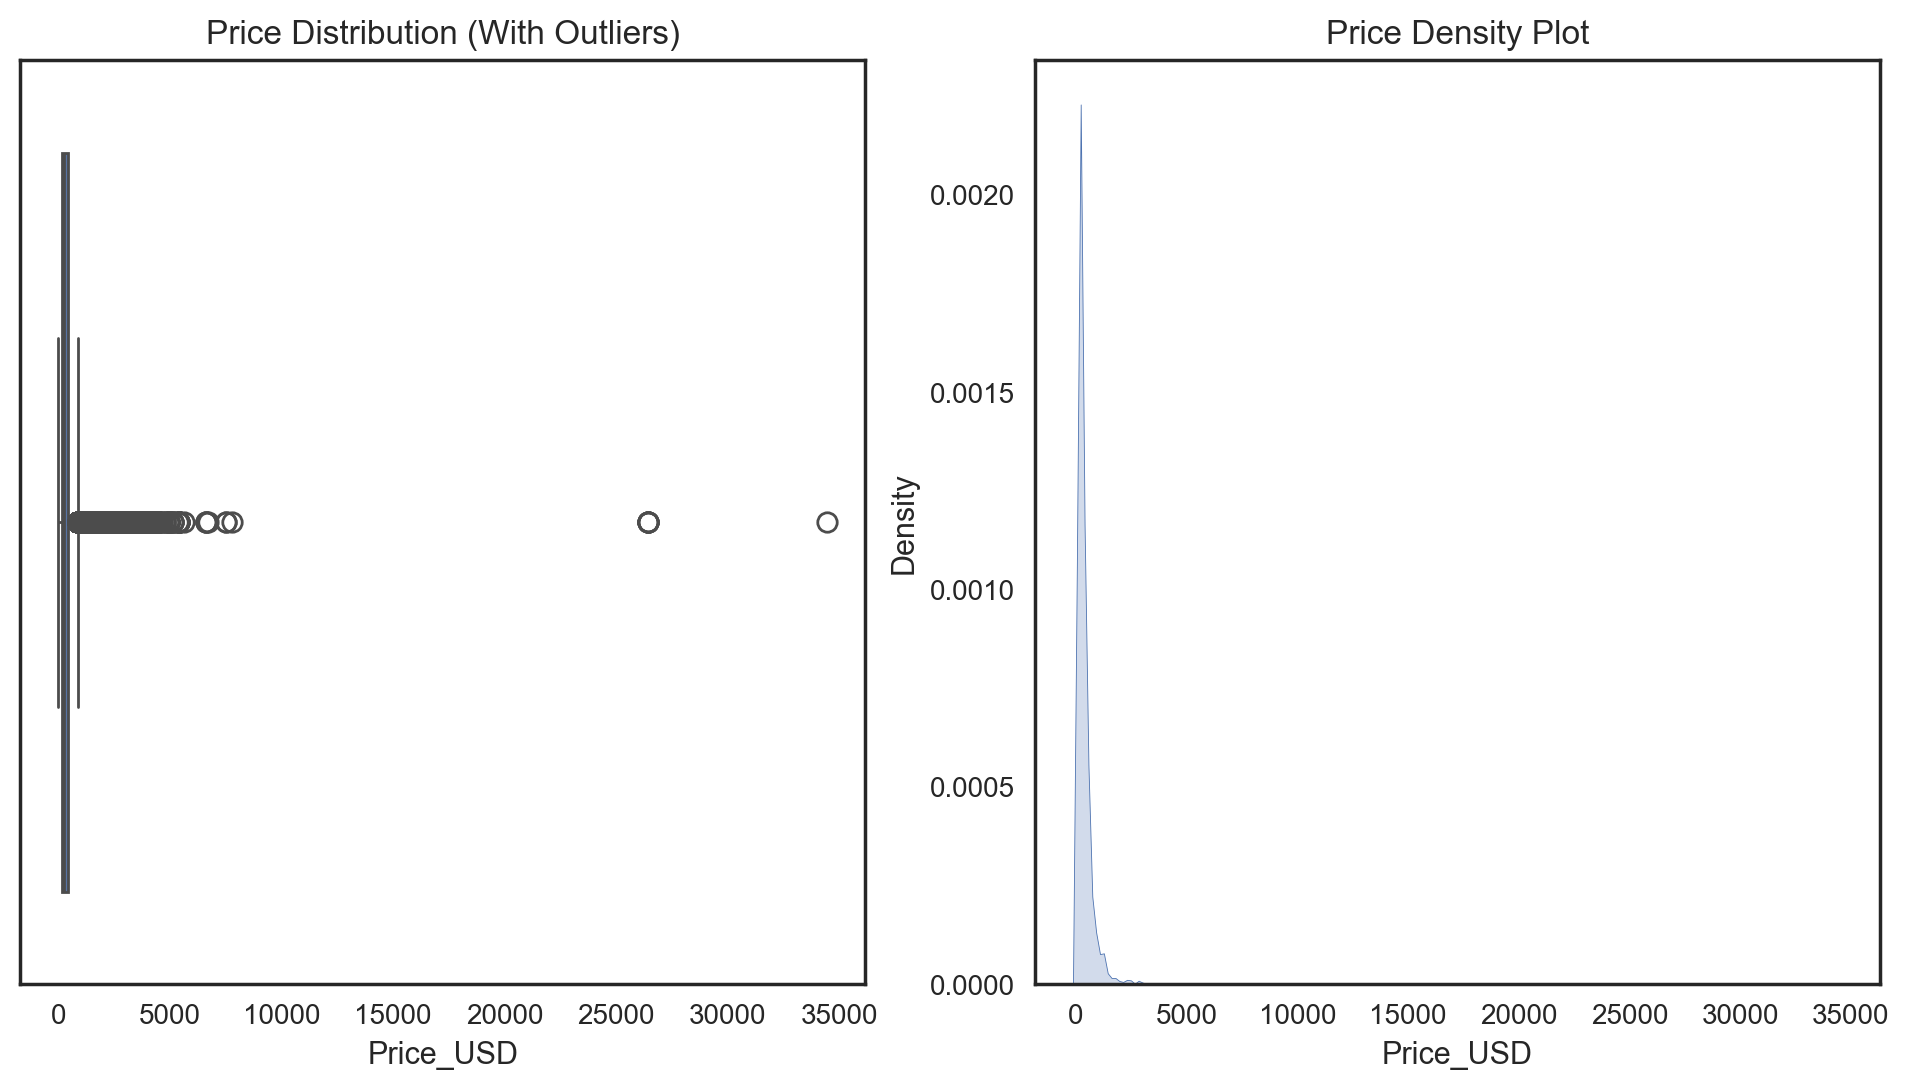

The Price skewness: 18.95906072625981
The Price kurtosis: 1054.8979068506155


In [14]:
# Distribution of Price_USD
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Price_USD', showfliers=True)
plt.title("Price Distribution (With Outliers)")

plt.subplot(1, 2, 2)
sns.kdeplot(data=df['Price_USD'], shade=True)
plt.title("Price Density Plot")
plt.show()

# Check skewness and kurtosis of Price_USD
print(f"The Price skewness: {df['Price_USD'].skew()}")
print(f"The Price kurtosis: {df['Price_USD'].kurtosis()}")


# Comment

# 1.5 Univariate Analysis of Categorical Features

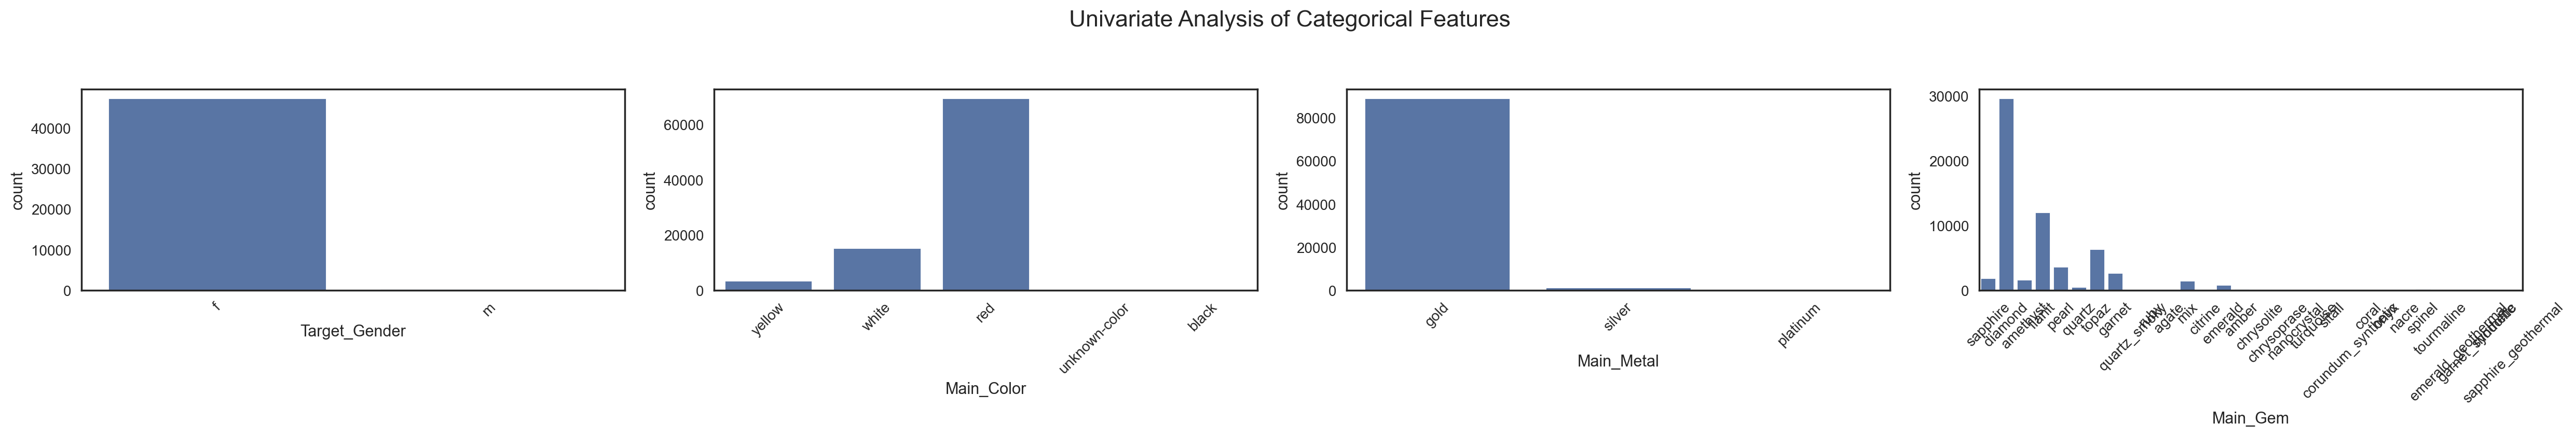

In [18]:
#Categorical features - Univaraite analysis
categorical_features = ['Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']

fig, axes = plt.subplots(1, len(categorical_features), figsize=(25, 4))
plt.suptitle("Univariate Analysis of Categorical Features", fontsize=16, y=1.05)

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 2.0 Data Preprocessing
# 2.1 Filter Relevant Jewelry Categories

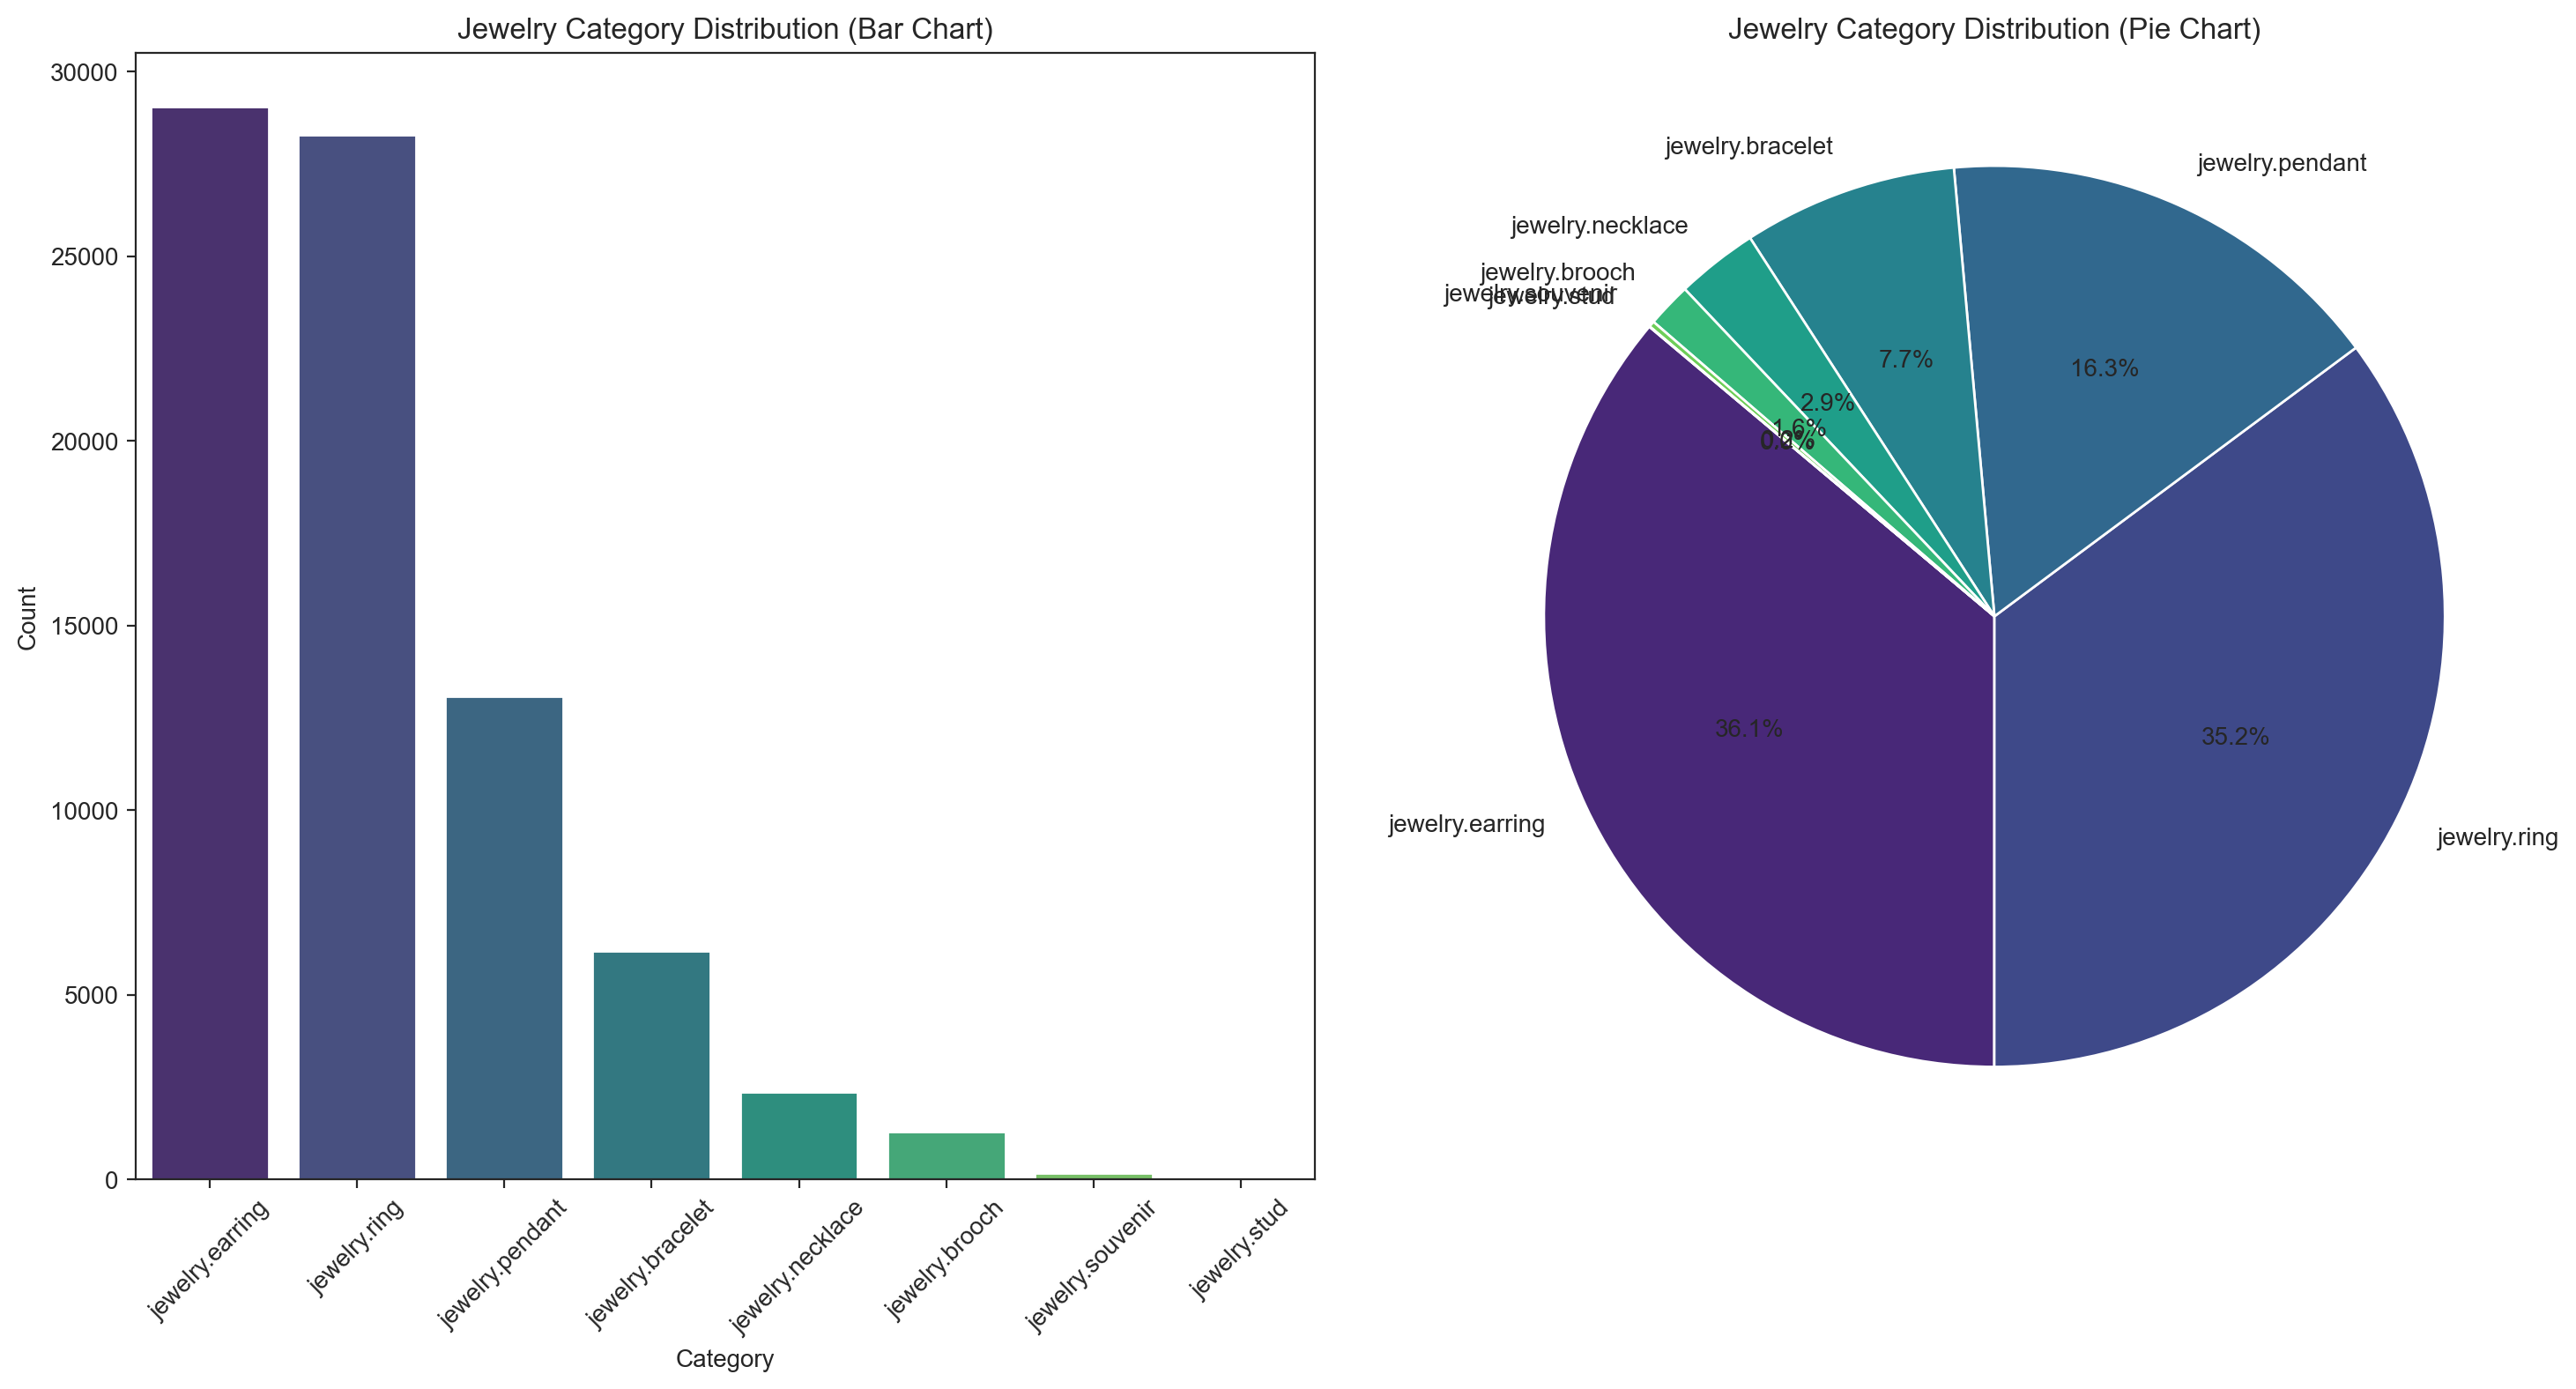

In [5]:
# Filter jewelry-related categories
jewelry_categories = [
    'jewelry.pendant', 'jewelry.necklace', 'jewelry.earring', 
    'jewelry.ring', 'jewelry.brooch', 'jewelry.bracelet',
    'jewelry.souvenir', 'jewelry.stud'
]
df_cleaned = df[df['Category'].isin(jewelry_categories)].reset_index(drop=True)

# Prepare data for visualization
category_counts = df_cleaned['Category'].value_counts()

# Create the figure and axes for side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Bar chart
sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Jewelry Category Distribution (Bar Chart)")
axes[0].set_xticklabels(category_counts.index, rotation=45)
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(category_counts)))
axes[1].set_title("Jewelry Category Distribution (Pie Chart)")

# Adjust layout
plt.tight_layout()
plt.show()


# 2.2 Jewelry Category by Gender


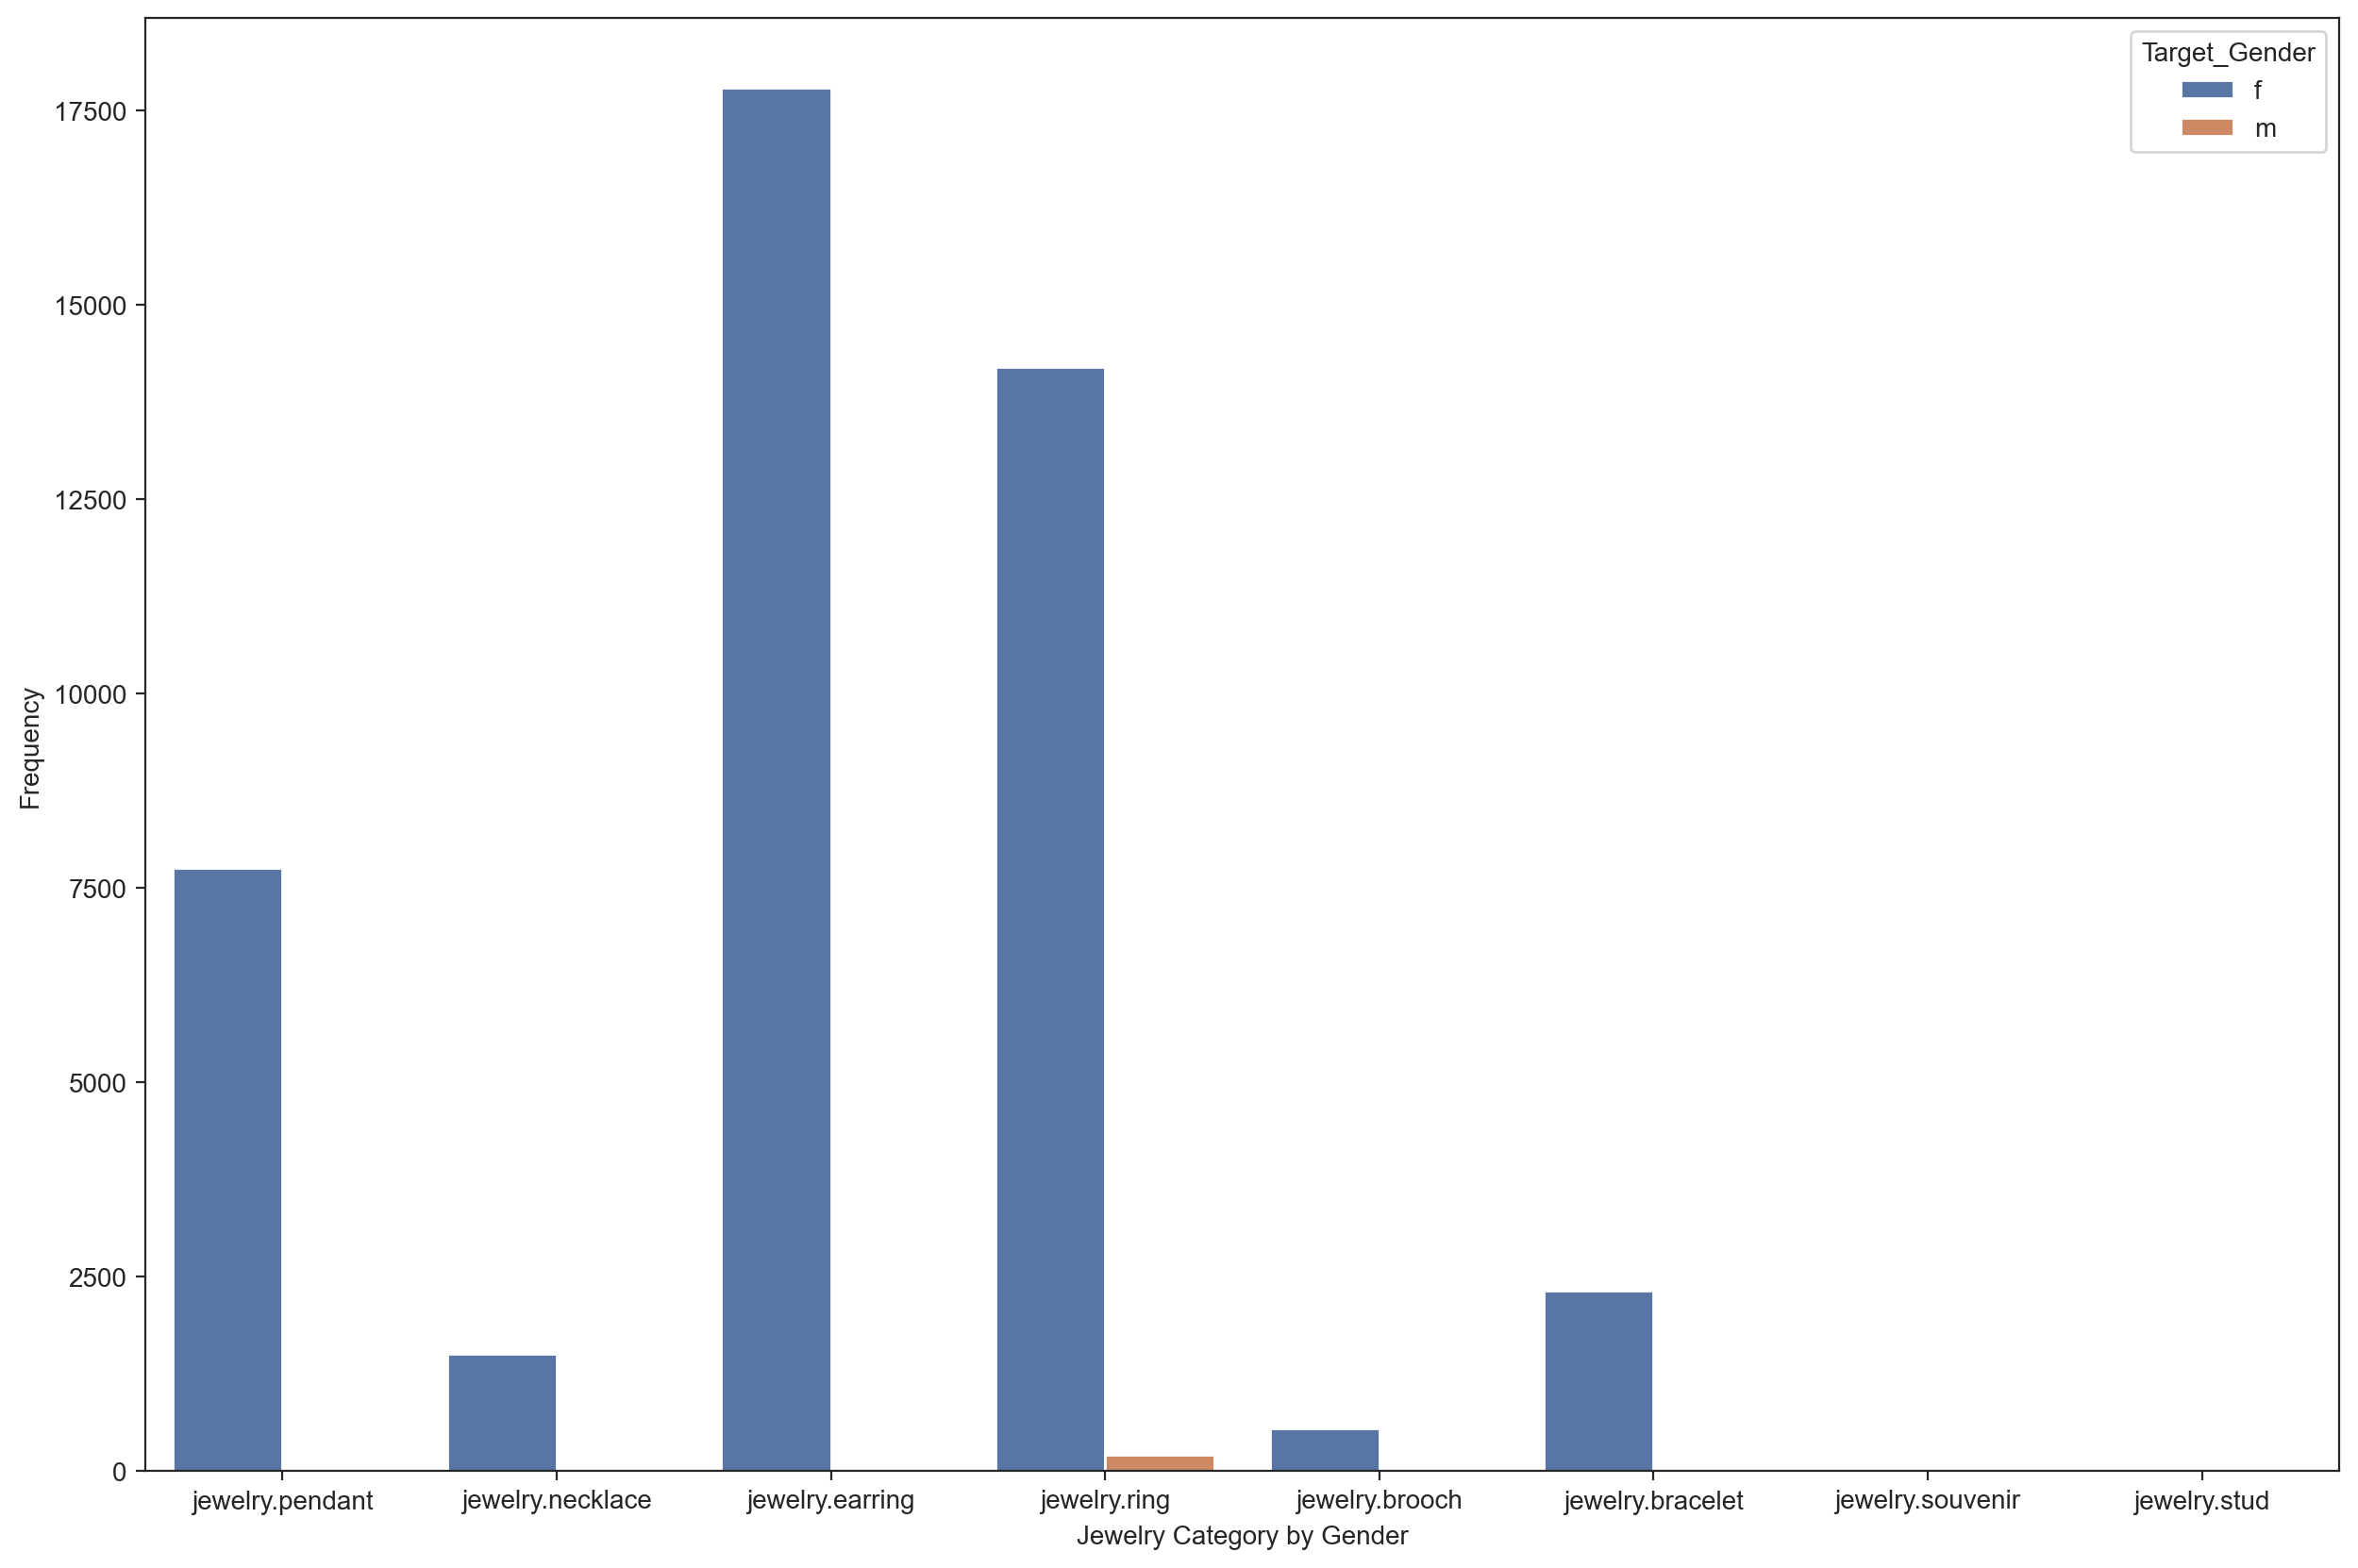

In [6]:
# Jewelry category by gender
plt.figure(figsize=(15,10))

sns.countplot(data = df_cleaned, x = 'Category', hue = 'Target_Gender')

plt.xlabel("Jewelry Category by Gender")
plt.ylabel("Frequency")
plt.show()

# 2.2 Handle Missing Values

In [7]:
def impute_missing_values(data, numerical_features, categorical_features):
    # Impute numerical features with mean
    num_imputer = SimpleImputer(strategy='mean')
    data[numerical_features] = num_imputer.fit_transform(data[numerical_features])
    
    # Impute categorical features with mode
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_features] = cat_imputer.fit_transform(data[categorical_features])
    
    return data

# Define feature types
categorical_features = ['Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
numerical_features = ['Brand_ID']

# Impute missing values
df_cleaned = impute_missing_values(df_cleaned, numerical_features, categorical_features)
print("Missing values handled successfully!")


Missing values handled successfully!


# 2.3 Drop Irrelevant Columns

In [8]:
# Drop unnecessary columns
columns_to_drop = ['Order_datetime', 'Order_ID', 'Product_ID', 'SKU_Quantity', 'Category_ID', 'User_ID']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

# Display the cleaned dataset
df_cleaned.head()


Category  Brand_ID  Price_USD Target_Gender Main_Color Main_Metal  \
0   jewelry.pendant       1.0      54.66             f      white       gold   
1   jewelry.pendant       0.0      88.90             f        red       gold   
2  jewelry.necklace       0.0     417.67             f        red       gold   
3   jewelry.earring       1.0     102.27             f        red       gold   
4   jewelry.earring       0.0     150.55             f        red       gold   

   Main_Gem  
0  sapphire  
1   diamond  
2  amethyst  
3   diamond  
4   diamond

In [9]:
# Check dataset shape
print(f"The Dataset shape is: {df_cleaned.shape}")

print("----------------------------------")

# Checking for missing values in dataset
df_cleaned.isnull().sum()

The Dataset shape is: (80458, 7)
----------------------------------


Category         0
Brand_ID         0
Price_USD        0
Target_Gender    0
Main_Color       0
Main_Metal       0
Main_Gem         0
dtype: int64

# 3.0 Advanced Correlation Analysis
# 3.1 Phik Correlation Heatmap

Available columns in DataFrame:
Index(['Category', 'Brand_ID', 'Price_USD', 'Target_Gender', 'Main_Color',
       'Main_Metal', 'Main_Gem'],
      dtype='object')


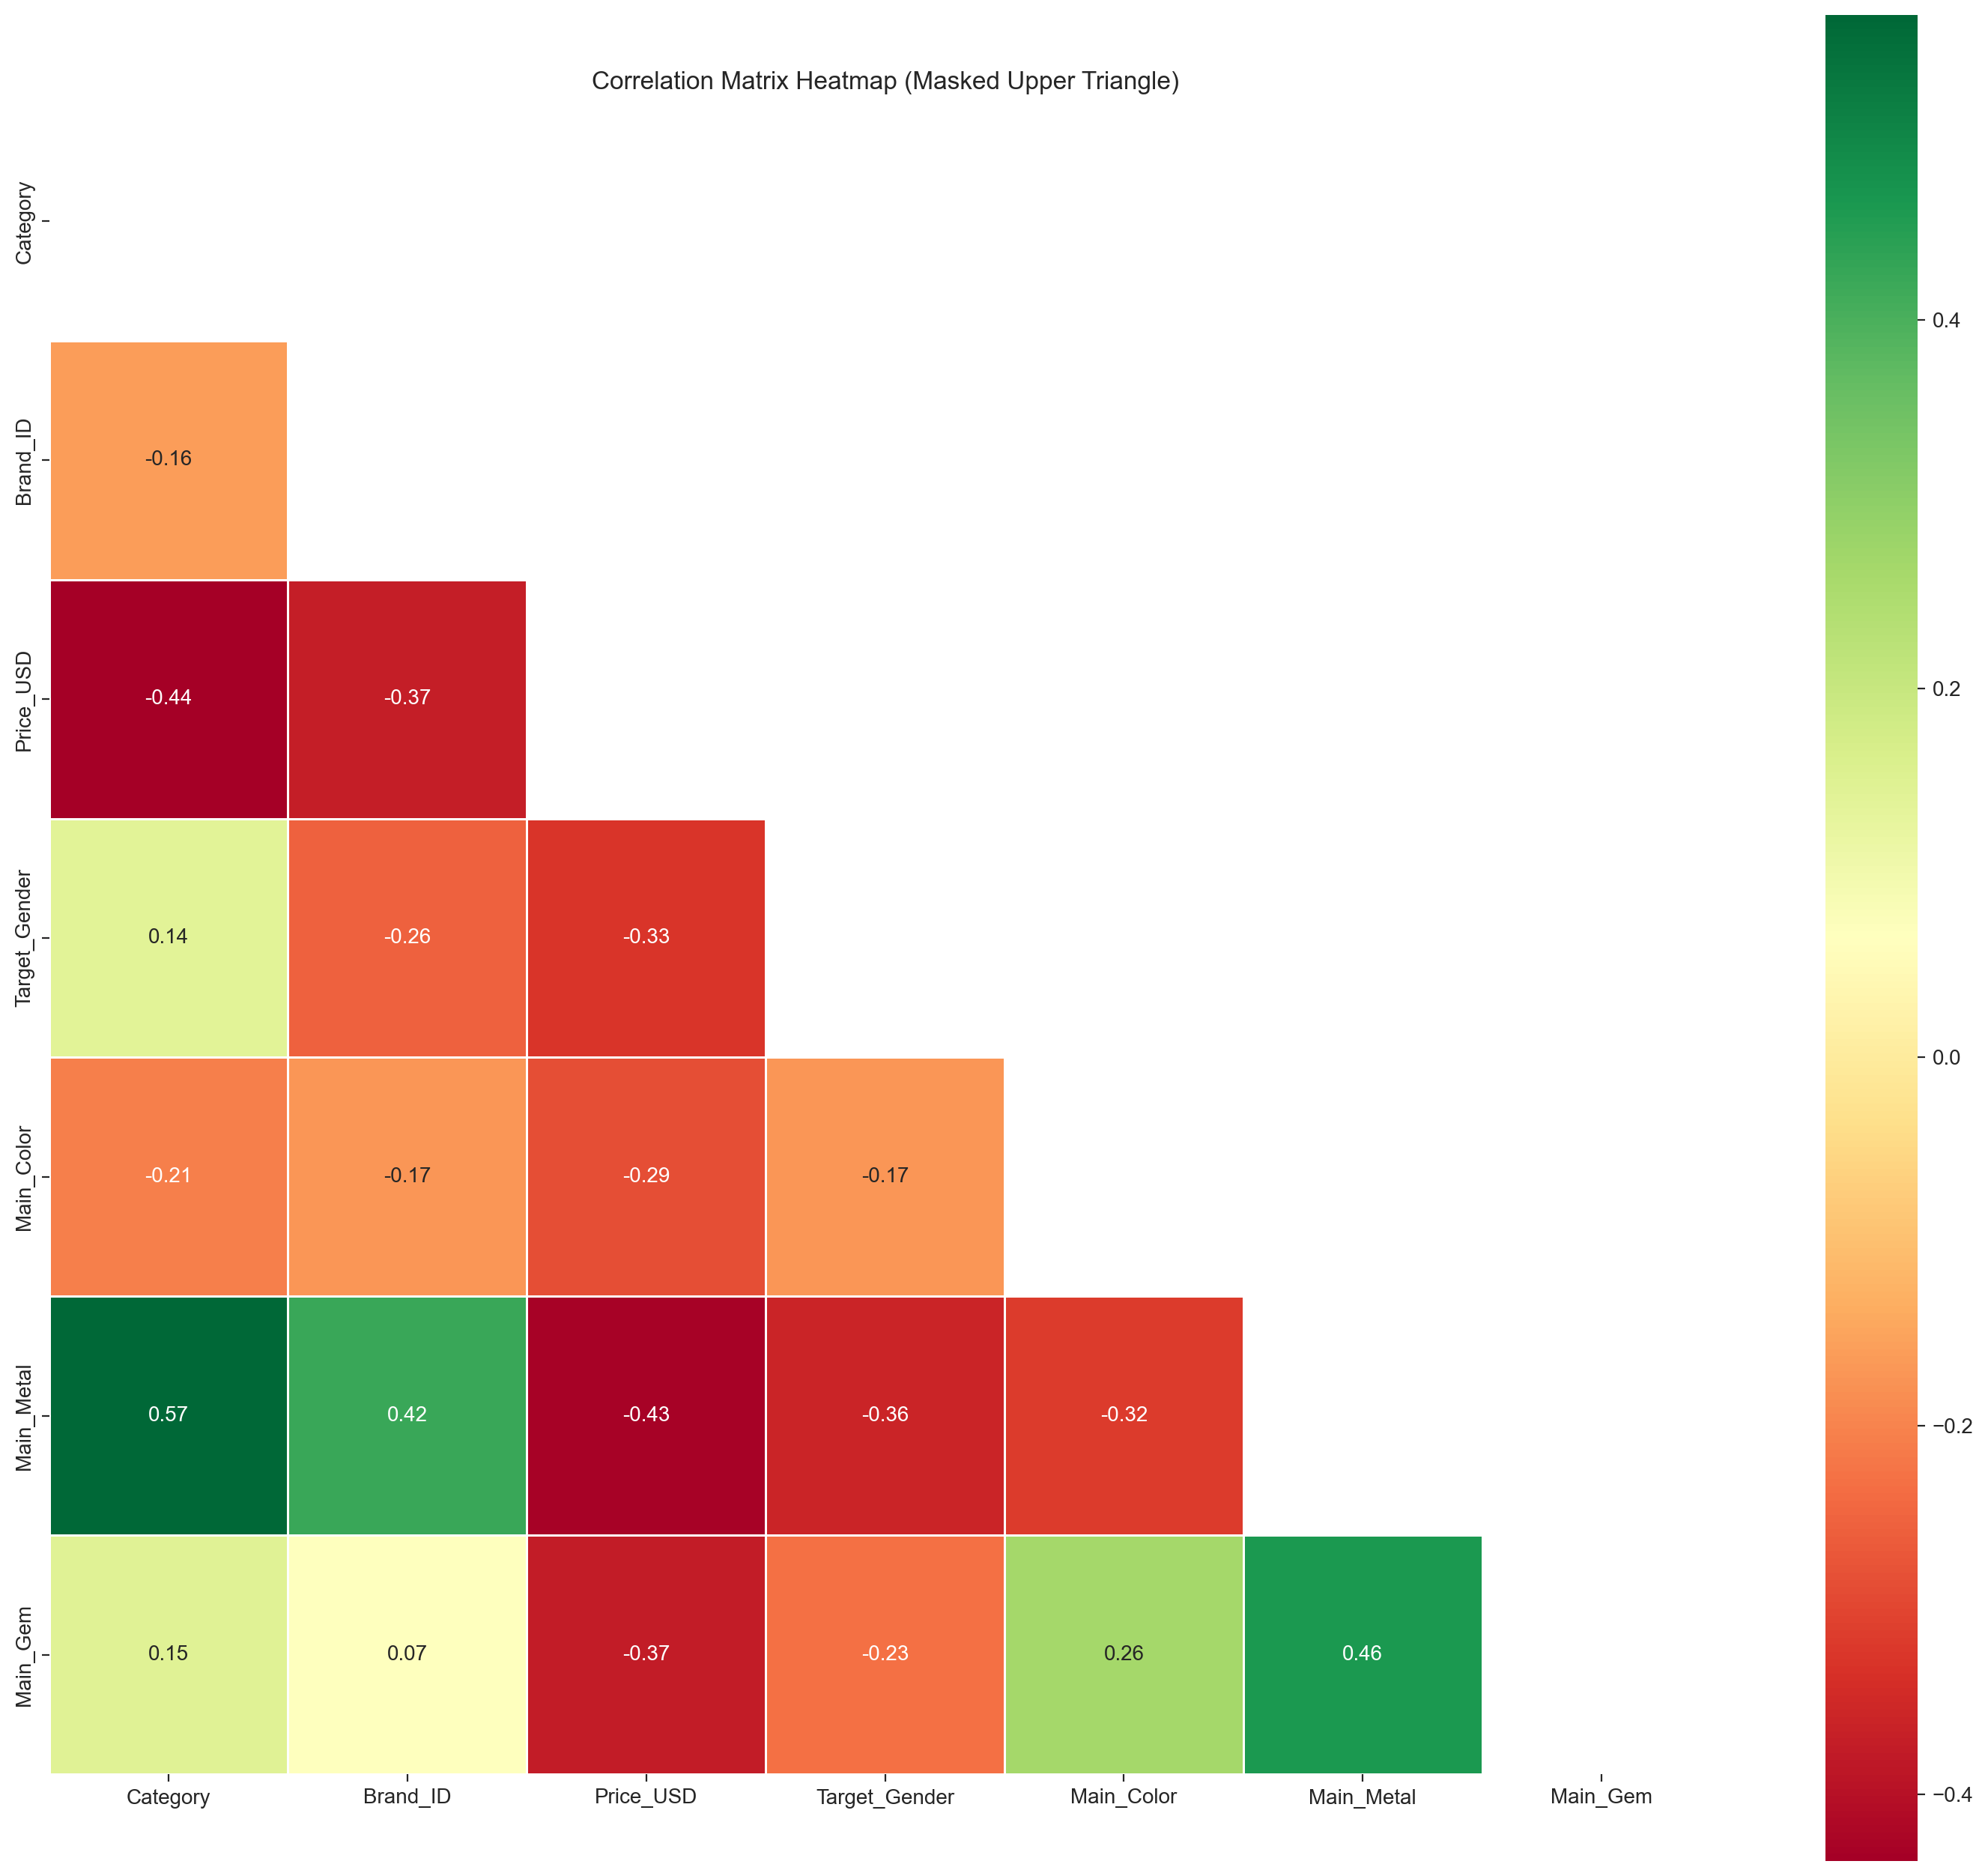

In [10]:
# Convert to DataFrame
df = pd.DataFrame(df_cleaned)

# Display available columns in the DataFrame
print("Available columns in DataFrame:")
print(df.columns)

# Ensure the 'Price_USD' column exists
if 'Price_USD' not in df.columns:
    raise KeyError("'Price_USD' column not found. Please check the correct column name.")

# Select numerical columns for Phik interval calculations
interval_cols = df.select_dtypes(include='number').columns

# Compute Phik matrix
phik_matrix_df = df.phik_matrix(interval_cols=interval_cols)

# # Plot the Phik Matrix Heatmap
# plt.figure(figsize=(14, 12))
# sns.heatmap(phik_matrix_df, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10}, square=True)
# plt.title("Phik Matrix Heatmap")
# plt.show()

# Calculate the correlation matrix from the Phik matrix
corr_matrix = phik_matrix_df.corr()

# Create a mask for the upper triangle using NumPy's triu function
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap with the mask applied
plt.figure(figsize=(18, 16))
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    square=True, 
    annot=True, 
    cmap='RdYlGn', 
    linewidths=0.5, 
    fmt=".2f", 
    annot_kws={"size": 10}
)
plt.title("Correlation Matrix Heatmap (Masked Upper Triangle)")
plt.show()


# 3.2 Standard Correlation Analysis

In [16]:
# Calculate correlation matrix
corr_matrix = df_cleaned.corr()

# Plot heatmap of correlation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f", mask=np.triu(corr_matrix))
plt.title("Correlation Heatmap")
plt.show()


ValueError: could not convert string to float: 'jewelry.pendant'

 # Outlier detection

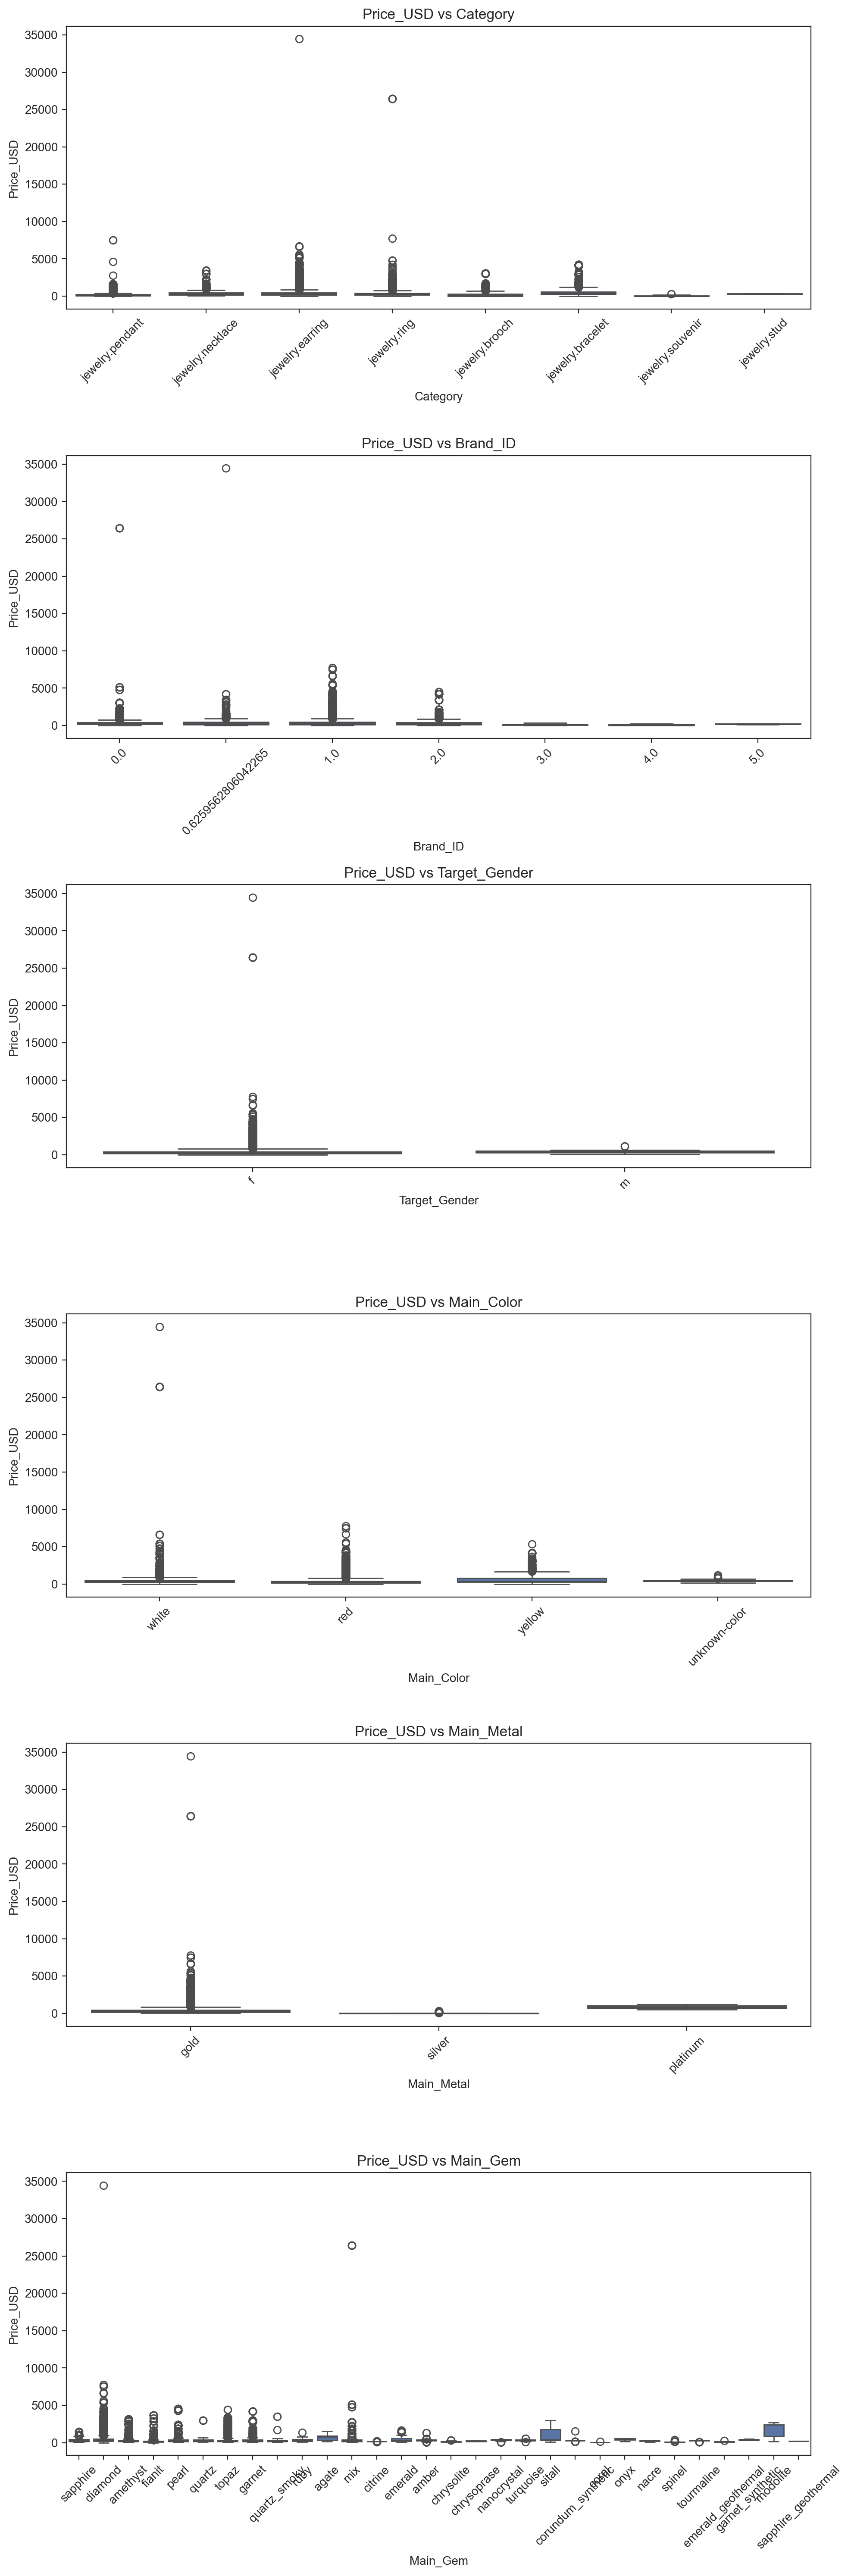

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical columns
categories = ['Category', 'Brand_ID', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']

# Number of subplots
n = len(categories)

# Create subplots
fig, axes = plt.subplots(n, 1, figsize=(10, 5 * n))

for i, col in enumerate(categories):
    ax = axes[i] if n > 1 else axes  # For single subplot case
    sns.boxplot(data=df_cleaned, x=col, y='Price_USD', ax=ax)
    ax.set_title(f'Price_USD vs {col}')
    ax.set_ylabel('Price_USD')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability if necessary

plt.tight_layout()
plt.show()


In [115]:
# # Code for Log Transformation:
# import numpy as np

# # Apply log transformation to Price_USD
# new_df['Log_Price_USD'] = np.log1p(new_df['Price_USD'])  # log1p to handle values close to 0
# new_df.head()

In [ ]:
# # Calculate IQR
# Q1 = new_df['Price_USD'].quantile(0.25)
# Q3 = new_df['Price_USD'].quantile(0.75)
# IQR = Q3 - Q1

# # Define outlier thresholds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out outliers
# new_df_no_outliers = new_df[(new_df['Price_USD'] >= lower_bound) & (new_df['Price_USD'] <= upper_bound)]

# # Display the shape of the new dataset
# print(new_df_no_outliers.shape)


In [ ]:
# from scipy.stats import zscore

# # Compute z-scores for Price_USD
# new_df['Price_Z_Score'] = zscore(new_df['Price_USD'])

# # Filter out outliers
# new_df_no_outliers = new_df[new_df['Price_Z_Score'].abs() <= 3]

# # Drop the temporary z-score column
# new_df_no_outliers.drop(columns=['Price_Z_Score'], inplace=True)

# # Display the shape of the new dataset
# print(new_df_no_outliers.shape)


In [12]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest on the data
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_cleaned['Outlier'] = iso_forest.fit_predict(df_cleaned[['Price_USD']])

# Filter out detected outliers
new_df_no_outliers = df_cleaned[df_cleaned['Outlier'] == 1].drop(columns=['Outlier'])

# Rename the cleaned dataset
cleaned_data = new_df_no_outliers

# Display the first few rows of the cleaned data
print(cleaned_data.shape)
cleaned_data.describe()


(79654, 7)


Brand_ID     Price_USD
count  79654.000000  79654.000000
mean       0.622687    326.268973
std        0.675770    269.994335
min        0.000000      0.990000
25%        0.000000    143.700000
50%        0.625956    246.440000
75%        1.000000    410.820000
max        5.000000   1830.140000

# Comment
1.isolation
Since Price_USD likely has a skewed distribution due to the large difference between the mean (352.33) and max (34,448.6), applying a log transformation will reduce the impact of extreme values.



# ENCODING THE CATEGORICAL FEATURES

In [ ]:
# # Define the categorical columns for target encoding
# cat_cols = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
# # Define the numerical columns and target
# num_cols = ['Brand_ID']
# target = ['Price_USD']
# # Target encode categorical columns
# encoder = ce.TargetEncoder(cols=cat_cols)
# df_encoded = new_df.copy()
# df_encoded[cat_cols] = encoder.fit_transform(new_df[cat_cols], new_df[target])
# # Concatenate encoded categorical features with numerical features
# df_encoded = pd.concat([df_encoded[cat_cols], new_df[num_cols], new_df[target]], axis=1)
# # Rename columns for clarity
# df_encoded.columns = [f'{col}' for col in cat_cols] + num_cols + target
# # Display the resulting DataFrame
# df_encoded.head(2)

Category  Target_Gender  Main_Color  Main_Metal    Main_Gem  Brand_ID  \
0  168.143564     352.264698  416.487640   356.99158  318.097481       1.0   
1  168.143564     352.264698  323.426024   356.99158  393.217171       0.0   

   Price_USD  
0      54.66  
1      88.90

# SPLIT INTO TRAIN_TEST SPLIT

In [ ]:
# # Specify a random seed
# seed = 42 # to ensure reproducibility
# random_state = seed
# # Load data and set X (features) and y (target)
# X = df_encoded.drop('Price_USD', axis=1)
# y = df_encoded['Price_USD']
# # Train_test_split
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=seed)

# print("X_train shape: ", X_train.shape, "; y_train shape: ", y_train.shape)
# print("X_test shape: ", X_test.shape, "; y_test shape: ", y_test.shape)
# #check the first row for X-train data
# X_train.head(2)

X_train shape:  (56320, 6) ; y_train shape:  (56320,)
X_test shape:  (24138, 6) ; y_test shape:  (24138,)


Category  Target_Gender  Main_Color  Main_Metal    Main_Gem  Brand_ID
44429  366.235013     352.264698  416.487640   356.99158  393.217171       0.0
51286  396.256655     352.264698  323.426024   356.99158  179.254268       0.0

In [ ]:
#check the first row for X-test data
# X_test.head(1)

Category  Target_Gender  Main_Color  Main_Metal    Main_Gem  Brand_ID
80387  366.235013     352.264698  323.426024   356.99158  393.217171       1.0

In [ ]:
# #check the first row for y-train data
# y_train.head(1)

44429    445.07
Name: Price_USD, dtype: float64

# # SCALING THE X- PREDICTORS

In [ ]:
# # Scaling the X predictors (for linear Regression and Polynomial features)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train) # fit scaler to the training data
# X_test_scaled = scaler.transform(X_test)       # fit scaler to the test data

# print("Number of features in training data:", X_train_scaled.shape[1])
# print("Number of features in test data:", X_test_scaled.shape[1])

Number of features in training data: 6
Number of features in test data: 6


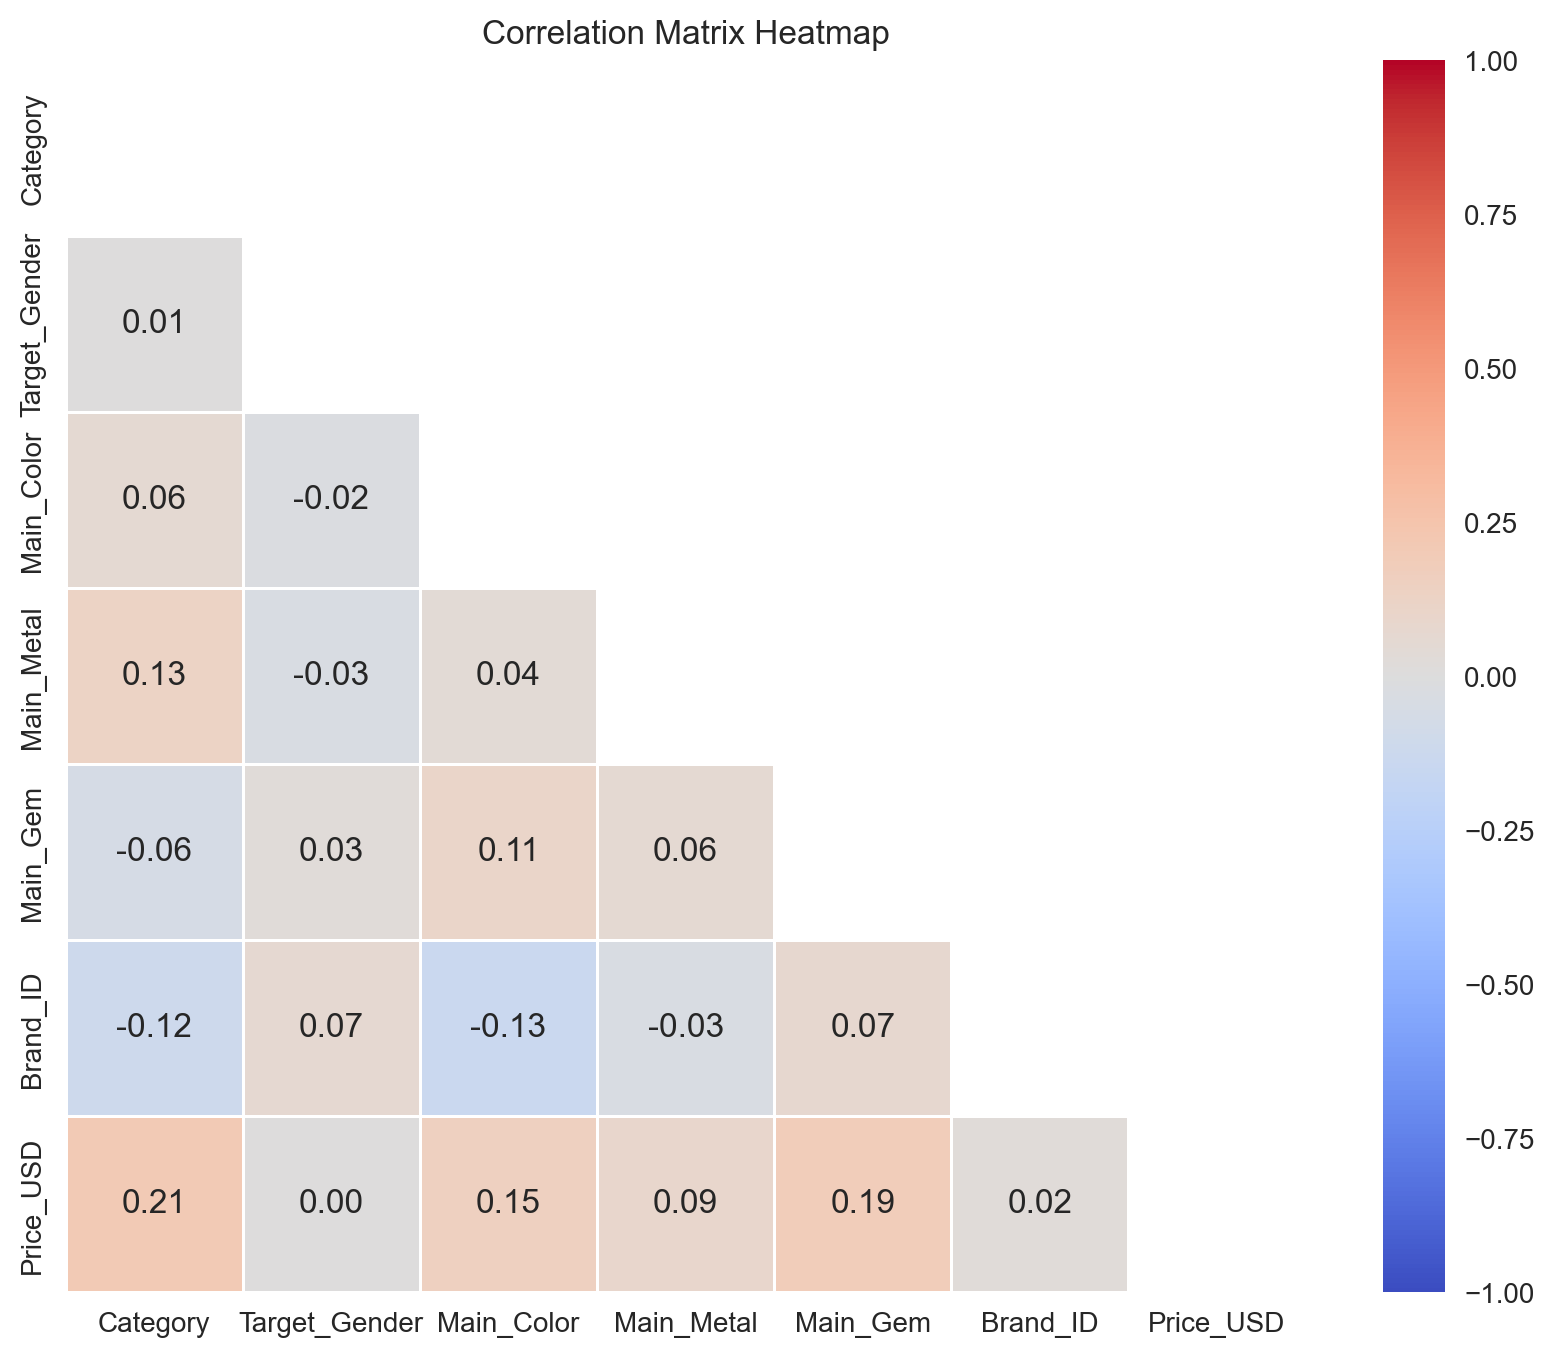

In [ ]:
# # Calculate correlation matrix
# corr_matrix =df_encoded.corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# # Set up the matplotlib figure
# plt.figure(figsize=(10, 8))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)

# plt.title('Correlation Matrix Heatmap')
# plt.show()

In [ ]:
# # Set a threshold for correlation coefficient
# threshold = 0.5

# # Find features with high absolute correlation coefficients
# high_correlation_features = set()
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if abs(corr_matrix.iloc[i, j]) > threshold:
#             feature_i = corr_matrix.columns[i]
#             feature_j = corr_matrix.columns[j]
#             high_correlation_features.add((feature_i, feature_j))

# # Print the features with high absolute correlation coefficients
# print("Features with high absolute correlation coefficients greater than 0.5:")
# for features in high_correlation_features:
#     print(features)

Features with high absolute correlation coefficients greater than 0.5:


# .2 Automatic Feature Selection 

In [ ]:
# #Automatic Feature Selection
# X = df_encoded.drop(columns=["Price_USD"])
# y = df_encoded["Price_USD"]  # Replace with actual target variable if needed

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# def select_features(X_train, y_train, method, k=5):
#     if method == "SelectKBest":
#         selector = SelectKBest(score_func=f_regression, k=k)
#     elif method == "RFE":
#         model = RandomForestRegressor(random_state=42)
#         selector = RFE(estimator=model, n_features_to_select=k)
#     elif method == "SFS":
#         model = RandomForestRegressor(random_state=42)
#         selector = SFS(estimator=model, n_features_to_select=k, direction='forward', scoring='r2', cv=5)
#     else:
#         raise ValueError("Invalid method. Choose 'SelectKBest', 'RFE', or 'SFS'.")
#     selector.fit(X_train, y_train)
#     return X_train.columns[selector.get_support()]

# print("SelectKBest Features:", select_features(X_train, y_train, "SelectKBest"))
# print("RFE Features:", select_features(X_train, y_train, "RFE"))
# print("SFS Features:", select_features(X_train, y_train, "SFS"))


SelectKBest Features: Index(['Category', 'Main_Color', 'Main_Metal', 'Main_Gem', 'Brand_ID'], dtype='object')
RFE Features: Index(['Category', 'Main_Color', 'Main_Metal', 'Main_Gem', 'Brand_ID'], dtype='object')
SFS Features: Index(['Category', 'Main_Color', 'Main_Metal', 'Main_Gem', 'Brand_ID'], dtype='object')


# PCA

In [ ]:
# def scale_features(data, exclude_columns):
#     scaler = StandardScaler()
#     columns_to_scale = data.columns.difference(exclude_columns)
#     data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
#     return data

# exclude_columns = ['Price_USD']
# df_scaled = scale_features(df_encoded.copy(), exclude_columns)
# print("Feature scaling completed!")


Feature scaling completed!


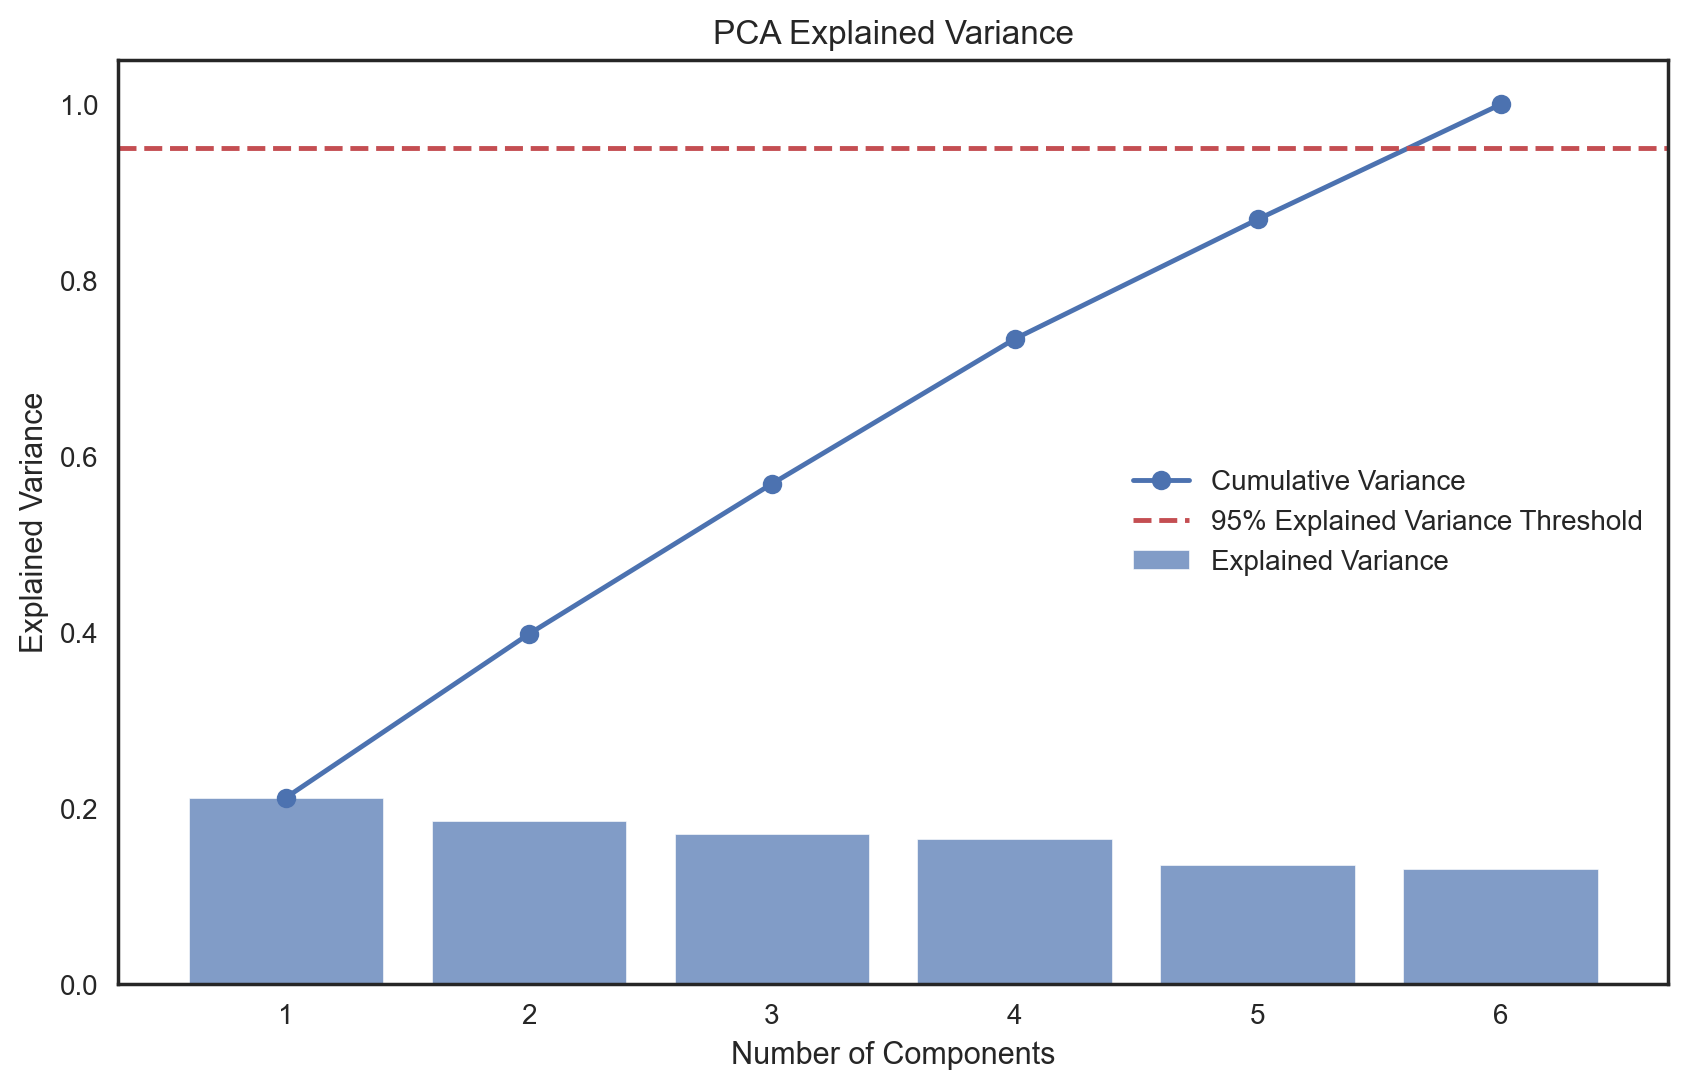

In [ ]:
# # Ensure CustomerID is the index to avoid it being included in PCA
# if 'Price_USD' in df_scaled.columns:
#     df_scaled.set_index('Price_USD', inplace=True)

# def apply_pca(data, n_components=6):
#     pca = PCA(n_components=n_components)
#     pca_data = pca.fit_transform(data)
#     pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(n_components)], index=data.index)
#     return pca, pca_df

# def plot_pca_variance(pca):
#     explained_variance_ratio = pca.explained_variance_ratio_
#     cumulative_variance = np.cumsum(explained_variance_ratio)
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(1, len(cumulative_variance) + 1), explained_variance_ratio, alpha=0.7, label='Explained Variance')
#     plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
#     plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance Threshold')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Explained Variance')
#     plt.title('PCA Explained Variance')
#     plt.legend()
#     plt.show()

# # Apply PCA and plot variance
# pca, customer_data_pca = apply_pca(df_scaled, n_components=6)
# plot_pca_variance(pca)


In [ ]:
# # Creating a PCA object with 6 components
# pca = PCA(n_components=6)

# # Fitting and transforming the original data to the new PCA dataframe
# new_data_pca = pca.fit_transform(df_scaled)

# # Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
# new_data_pca = pd.DataFrame(new_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# # Adding the CustomerID index back to the new PCA dataframe
# new_data_pca.index = df_scaled.index
# # Displaying the resulting dataframe based on the PCs
# new_data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
Price_USD                                                            
54.66      0.865454  0.601369 -1.078459 -0.116659 -1.015200  1.465140
88.90      0.677181  0.398317 -1.098203 -0.272820 -1.769878 -0.599973
417.67    -0.578544 -0.355889  0.066214  0.031784 -0.265453 -0.833818
102.27     0.183096  0.301562  0.574126 -0.384005  0.534213 -0.329994
150.55    -0.629306 -0.087460  0.089579  0.005051 -0.155416 -1.055459

In [ ]:
# # Define a function to highlight the top 3 absolute values in each column of a dataframe
# def highlight_top3(column):
#     top3 = column.abs().nlargest(4).index
#     return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# # Create the PCA component DataFrame and apply the highlighting function
# pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
#                      index=df_scaled.columns)

# pc_df.style.apply(highlight_top3, axis=0)

#Comment
In summary, PCA highlights that branding, product type, aesthetic features, and gender targeting are crucial factors influencing jewelry pricing. This can guide focused price optimization and marketing strategies.

Final Ranking:
Brand_ID (2.556273) – Most important
Category (2.031020)
Target_Gender (1.958233)
Main_Metal (1.841257)
Main_Color (1.708274)
Main_Gem (1.676945) – Least important
Insights:
Brand_ID dominates, suggesting branding has the greatest impact on pricing.
Category and Target_Gender follow, highlighting the importance of product type and targeted demographics.
Aesthetic features like Main_Metal, Main_Color, and Main_Gem play supporting roles but are less influential overall.

# MODEL 

In [13]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from scipy.stats import skew
import numpy as np
import pandas as pd

In [14]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# MLflow Setup
mlflow.set_tracking_uri(uri="http://localhost:5000")
mlflow.set_experiment("Jewelry Price Optimization")

2024/11/28 12:00:10 INFO mlflow.tracking.fluent: Experiment with name 'Jewelry Price Optimization' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1732795210172, experiment_id='1', last_update_time=1732795210172, lifecycle_stage='active', name='Jewelry Price Optimization', tags={}>

In [ ]:
# def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
#     """
#     Split the dataset into train and test sets.
#     """
#     X = df.drop(columns=[target_column])
#     y = df[target_column]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#     return X_train, X_test, y_train, y_test

# def create_pipeline():
#     """
#     Create preprocessing pipeline for filling missing values and encoding categorical variables.
#     """
#     categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
#     numerical_features = ['Brand_ID']

#     # Pipelines for numerical and categorical preprocessing
#     cat_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('target_encoder', TargetEncoder())
#     ])
#     num_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='mean'))
#     ])

#     # Combine into a column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_pipeline, numerical_features),
#             ('cat', cat_pipeline, categorical_features)
#         ]
#     )
#     return preprocessor

In [ ]:
# def evaluate_model(y_test, preds, model_name):
#     """
#     Evaluate the model's performance using MAE, MSE, and R².
#     """
#     mae = mean_absolute_error(y_test, preds)
#     mse = mean_squared_error(y_test, preds)
#     r2 = r2_score(y_test, preds)
#     print(f"{model_name} Performance:")
#     print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")

# def tune_hyperparameters(model, param_grid, X_train, y_train):
#     """
#     Perform grid search for hyperparameter tuning.
#     """
#     grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
#     grid_search.fit(X_train, y_train)
#     print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
#     return grid_search

# def log_model_with_mlflow(model, model_name, X_train, y_train):
#     """
#     Log the model and its metrics using MLflow.
#     """
#     with mlflow.start_run(run_name=model_name):
#         mlflow.log_params(model.best_params_)
#         mlflow.log_metric("train_score", model.best_score_)

#         # Logging metrics
#         preds = model.best_estimator_.predict(X_train)
#         mae = mean_absolute_error(y_train, preds)
#         mse = mean_squared_error(y_train, preds)
#         r2 = r2_score(y_train, preds)

#         mlflow.log_metric("MAE", mae)
#         mlflow.log_metric("MSE", mse)
#         mlflow.log_metric("R2", r2)

#         # Log the model itself
#         if isinstance(model, GridSearchCV):  # Log best estimator
#             model_to_log = model.best_estimator_
#             if isinstance(model_to_log, RandomForestRegressor):
#                 mlflow.sklearn.log_model(model_to_log, "random_forest_model")
#             elif isinstance(model_to_log, XGBRegressor):
#                 mlflow.xgboost.log_model(model_to_log, "xgboost_model")

In [ ]:

# # Main workflow
# def main():
#     # Assuming 'new_df' is your dataset
#     X_train, X_test, y_train, y_test = split_data(new_df)

#     # Create preprocessing pipeline
#     preprocessor = create_pipeline()

#     # Transform training and testing data
#     X_train = preprocessor.fit_transform(X_train, y_train)
#     X_test = preprocessor.transform(X_test)

#     # Hyperparameter grids for models
#     rf_params = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [10, 20, None],
#         'min_samples_split': [2, 5, 10]
#     }

#     xgb_params = {
#         'learning_rate': [0.01, 0.1, 0.2],
#         'n_estimators': [100, 200],
#         'max_depth': [3, 5, 7]
#     }

#     # Model Hyperparameter Tuning
#     rf_model = RandomForestRegressor(random_state=42)
#     xgb_model = XGBRegressor(random_state=42)

#     rf_grid = tune_hyperparameters(rf_model, rf_params, X_train, y_train)
#     xgb_grid = tune_hyperparameters(xgb_model, xgb_params, X_train, y_train)

#     # Predictions for evaluation
#     rf_preds = rf_grid.best_estimator_.predict(X_test)
#     xgb_preds = xgb_grid.best_estimator_.predict(X_test)

#     # Evaluate models
#     evaluate_model(y_test, rf_preds, "Random Forest")
#     evaluate_model(y_test, xgb_preds, "XGBoost")

#     # Log models and metrics with MLflow
#     log_model_with_mlflow(rf_grid, "Random Forest", X_train, y_train)
#     log_model_with_mlflow(xgb_grid, "XGBoost", X_train, y_train)

# # Run the pipeline
# if __name__ == "__main__":
#     main()


Best parameters for RandomForestRegressor: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for XGBRegressor: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Random Forest Performance:
MAE: 177.24200896653005, MSE: 156808.67676827576, R²: 0.24337534919026893

XGBoost Performance:
MAE: 177.0252820521383, MSE: 156397.35448427667, R²: 0.24536003897858327



2024/11/27 14:15:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/489109835537272907/runs/a302334645d04959bf3ce075ed8539cb
🧪 View experiment at: http://localhost:5000/#/experiments/489109835537272907


2024/11/27 14:15:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/489109835537272907/runs/3c2982e1f7b74ba68b58f0ed234fdf90
🧪 View experiment at: http://localhost:5000/#/experiments/489109835537272907


In [17]:
import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew
import numpy as np
import pandas as pd

# MLflow Setup
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Jewelry Price Optimization")

def split_data(cleaned_data, target_column='Price_USD', test_size=0.3, random_state=42):
    """
    Split the dataset into train and test sets.
    """
    X = cleaned_data.drop(columns=[target_column])
    y = cleaned_data[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def create_pipeline():
    """
    Create preprocessing pipeline for filling missing values and encoding categorical variables.
    """
    categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
    numerical_features = ['Brand_ID']

    # Define pipelines for categorical and numerical features
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_encoder', TargetEncoder())
    ])
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Combine pipelines
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_features),
            ('cat', cat_pipeline, categorical_features)
        ]
    )
    return preprocessor

def preprocess_data(X_train, X_test, preprocessor):
    """
    Apply preprocessing pipeline to the train and test data.
    """
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

def evaluate_model(y_test, preds, model_name):
    """
    Evaluate the model's performance using MAE, MSE, and R².
    """
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")

def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation for hyperparameter tuning.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search

def log_model_with_mlflow(model, model_name, X_train, y_train, preprocessor):
    """
    Log the model and its metrics using MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        if isinstance(model, GridSearchCV):
            mlflow.log_params(model.best_params_)

        # Logging metrics
        preds = model.best_estimator_.predict(X_train)
        mae = mean_absolute_error(y_train, preds)
        mse = mean_squared_error(y_train, preds)
        r2 = r2_score(y_train, preds)

        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("R2", r2)

        # Log the model and preprocessor
        mlflow.sklearn.log_model(model.best_estimator_, model_name)
        mlflow.sklearn.log_model(preprocessor, f"{model_name}_preprocessor")

# Main workflow
def main():
    # Assuming 'cleaned_data' is your dataset
    X_train, X_test, y_train, y_test = split_data(cleaned_data)

    # Create preprocessing pipeline
    preprocessor = create_pipeline()

    # Preprocess the data
    X_train_processed, X_test_processed = preprocess_data(X_train, X_test, preprocessor)

    # Hyperparameter grids for models
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
    xgb_params = {'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'n_estimators': [100, 200]}
    gbr_params = {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
    lgbm_params = {'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}

    # Initialize models
    models = [
        (RandomForestRegressor(random_state=42), rf_params, "Random Forest"),
        (XGBRegressor(random_state=42), xgb_params, "XGBoost"),
        (GradientBoostingRegressor(random_state=42), gbr_params, "Gradient Boosting"),
        (LGBMRegressor(random_state=42), lgbm_params, "LightGBM")
    ]

    for model, params, name in models:
        print(f"Tuning {name}...")
        tuned_model = tune_hyperparameters(model, params, X_train_processed, y_train)
        preds = tuned_model.best_estimator_.predict(X_test_processed)
        evaluate_model(y_test, preds, name)
        log_model_with_mlflow(tuned_model, name, X_train_processed, y_train, preprocessor)

# Run the pipeline
if __name__ == "__main__":
    main()


TypeError: fit_transform() missing argument: y

In [ ]:
# import mlflow
# import mlflow.sklearn
# import mlflow.xgboost
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
# from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# #from catboost import CatBoostRegressor
# from scipy.stats import skew
# import numpy as np
# import pandas as pd

# # # MLflow Setup
# mlflow.set_tracking_uri(uri="http://localhost:5000")
# mlflow.set_experiment("Jewelry Price Optimization")

# def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
#     """
#     Split the dataset into train and test sets.
#     """
#     X = cleaned_data.drop(columns=[target_column])
#     y = cleaned_data[target_column]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
#     return X_train, X_test, y_train, y_test

# def create_pipeline():
#     """
#     Create preprocessing pipeline for filling missing values and encoding categorical variables.
#     """
#     categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
#     numerical_features = ['Brand_ID']

#     # Pipelines for numerical and categorical preprocessing
#     cat_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('target_encoder', TargetEncoder())
#     ])
#     num_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='mean'))
#     ])

#     # Combine into a column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_pipeline, numerical_features),
#             ('cat', cat_pipeline, categorical_features)
#         ]
#     )
#     return preprocessor

# def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
#     """
#     Split the dataset into train and test sets.
#     """
#     X = cleaned_data.drop(columns=[target_column])
#     y = cleaned_data[target_column]
#     return train_test_split(X, y, test_size=test_size, random_state=random_state)

# def preprocess_data(X_train, X_test):
#     """
#     Apply preprocessing steps: handle skewed features, scale numerical features.
#     """
#     # Identify skewed numeric features
#     numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
#     skewed_features = X_train[numeric_features].apply(lambda x: skew(x)).index

#     # Apply log transformation for highly skewed features
#     transformer = PowerTransformer(method='box-cox', standardize=False)
#     for feature in skewed_features:
#         if X_train[feature].min() > 0:  # Box-Cox requires positive values
#             X_train[feature] = transformer.fit_transform(X_train[[feature]])
#             X_test[feature] = transformer.transform(X_test[[feature]])

#     # Scale numerical features
#     scaler = StandardScaler()
#     X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
#     X_test[numeric_features] = scaler.transform(X_test[numeric_features])

#     return X_train, X_test

# def evaluate_model(y_test, preds, model_name):
#     """
#     Evaluate the model's performance using MAE, MSE, and R².
#     """
#     mae = mean_absolute_error(y_test, preds)
#     mse = mean_squared_error(y_test, preds)
#     r2 = r2_score(y_test, preds)
#     print(f"{model_name} Performance:")
#     print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")

# def tune_hyperparameters(model, param_grid, X_train, y_train):
#     """
#     Perform grid search with cross-validation for hyperparameter tuning.
#     """
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
#     return grid_search

# def log_model_with_mlflow(model, model_name, X_train, y_train):
#     """
#     Log the model and its metrics using MLflow.
#     """
#     with mlflow.start_run(run_name=model_name):
#         mlflow.log_params(model.best_params_)
#         mlflow.log_metric("train_score", model.best_score_)

#         # Logging metrics
#         preds = model.best_estimator_.predict(X_train)
#         mae = mean_absolute_error(y_train, preds)
#         mse = mean_squared_error(y_train, preds)
#         r2 = r2_score(y_train, preds)

#         mlflow.log_metric("MAE", mae)
#         mlflow.log_metric("MSE", mse)
#         mlflow.log_metric("R2", r2)

#         # Log the model itself
#         if isinstance(model, GridSearchCV):  # Log best estimator
#             mlflow.sklearn.log_model(model.best_estimator_, model_name)

# # Main workflow
# def main():
#     # Assuming 'new_df' is your dataset
#     X_train, X_test, y_train, y_test = split_data(cleaned_data)

#     # Preprocess the data
#     X_train, X_test = preprocess_data(X_train, X_test)

#     # Hyperparameter grids for all models
#     rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
#     xgb_params = {'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'n_estimators': [100, 200]}
#     gbr_params = {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
#     lgbm_params = {'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}
#    # cat_params = {'depth': [6, 8], 'learning_rate': [0.05, 0.1], 'iterations': [200, 300]}

#     # Initialize models
#     rf_model = RandomForestRegressor(random_state=42)
#     xgb_model = XGBRegressor(random_state=42)
#     gbr_model = GradientBoostingRegressor(random_state=42)
#     lgbm_model = LGBMRegressor(random_state=42)
#     #cat_model = CatBoostRegressor(random_state=42, verbose=0)

#     # Tune hyperparameters
#     models = [
#         (rf_model, rf_params, "Random Forest"),
#         (xgb_model, xgb_params, "XGBoost"),
#         (gbr_model, gbr_params, "Gradient Boosting"),
#         (lgbm_model, lgbm_params, "LightGBM"),
#       #  (cat_model, cat_params, "CatBoost")
#     ]

#     for model, params, name in models:
#         print(f"Tuning {name}...")
#         tuned_model = tune_hyperparameters(model, params, X_train, y_train)
#         preds = tuned_model.best_estimator_.predict(X_test)
#         evaluate_model(y_test, preds, name)
#         log_model_with_mlflow(tuned_model, name, X_train, y_train)

# # Run the pipeline
# if __name__ == "__main__":
#     main()


Tuning Random Forest...


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        force_all_finite=False,
        ^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\utils\_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'jewelry.earring'

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        force_all_finite=False,
        ^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\utils\validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\sklearn\utils\_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Kenny Ogundana\OneDrive\Documents\amdari_projects\venv\Lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'jewelry.ring'


In [37]:
print(df_cleaned.head(1))

          Category  Brand_ID  Price_USD Target_Gender Main_Color Main_Metal  \
0  jewelry.pendant       1.0      54.66             f      white       gold   

   Main_Gem  
0  sapphire  


In [18]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from scipy.stats import skew
import numpy as np
import pandas as pd

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import skew
import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn

# MLflow Setup
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Jewelry Price Optimization")

def split_data(df, target_column='Price_USD', test_size=0.3, random_state=42):
    """
    Split the dataset into train and test sets.
    """
    X = cleaned_data.drop(columns=[target_column])
    y = cleaned_data[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def create_pipeline():
    """
    Create preprocessing pipeline for filling missing values and encoding categorical variables.
    """
    categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
    numerical_features = ['Brand_ID']

    # Pipelines for numerical and categorical preprocessing
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Combine into a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_features),
            ('cat', cat_pipeline, categorical_features)
        ]
    )
    return preprocessor

def preprocess_data(X_train, X_test, preprocessor):
    """
    Apply preprocessing steps to train and test datasets.
    """
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def evaluate_model(y_test, preds, model_name):
    """
    Evaluate the model's performance using MAE, MSE, and R².
    """
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")

def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform grid search with cross-validation for hyperparameter tuning.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search

def log_model_with_mlflow(model, model_name, X_train, y_train):
    """
    Log the model and its metrics using MLflow.
    """
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model.best_params_)
        mlflow.log_metric("train_score", model.best_score_)

        # Logging metrics
        preds = model.best_estimator_.predict(X_train)
        mae = mean_absolute_error(y_train, preds)
        mse = mean_squared_error(y_train, preds)
        r2 = r2_score(y_train, preds)

        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("MSE", mse)
        mlflow.log_metric("R2", r2)

        # Log the model itself
        if isinstance(model, GridSearchCV):  # Log best estimator
            mlflow.sklearn.log_model(model.best_estimator_, model_name)

# Main workflow
def main():
    # Assuming 'df_cleaned' is your dataset
   # df_cleaned = pd.read_csv("your_dataset.csv")  # Replace with your actual dataset
    X_train, X_test, y_train, y_test = split_data(cleaned_data)

    # Create and apply preprocessing pipeline
    preprocessor = create_pipeline()
    X_train, X_test = preprocess_data(X_train, X_test, preprocessor)

    # Hyperparameter grids for all models
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
    xgb_params = {'learning_rate': [0.05, 0.1], 'max_depth': [5, 7], 'n_estimators': [100, 200]}
    gbr_params = {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
    lgbm_params = {'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]}
    #cat_params = {'depth': [6, 8], 'learning_rate': [0.05, 0.1], 'iterations': [200, 300]}




    # Initialize models
    models = [
        (RandomForestRegressor(random_state=42), rf_params, "Random Forest"),
        (XGBRegressor(random_state=42), xgb_params, "XGBoost"),
        (GradientBoostingRegressor(random_state=42), gbr_params, "Gradient Boosting"),
        (LGBMRegressor(random_state=42), lgbm_params, "LightGBM"),
        #(CatBoostRegressor(random_state=42, verbose=0), cat_params, "CatBoost")
    ]

    # Tune, evaluate, and log models
    for model, params, name in models:
        print(f"Tuning {name}...")
        tuned_model = tune_hyperparameters(model, params, X_train, y_train)
        preds = tuned_model.best_estimator_.predict(X_test)
        evaluate_model(y_test, preds, name)
        log_model_with_mlflow(tuned_model, name, X_train, y_train)

# Run the pipeline
if __name__ == "__main__":
    main()


Tuning Random Forest...
Best parameters for RandomForestRegressor: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Performance:
MAE: 151.94856122630787, MSE: 51804.911852428275, R²: 0.30010459359565034



2024/11/28 12:22:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5000/#/experiments/1/runs/4acecfc766c4457a8a3e7a29fb186432
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning XGBoost...
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost Performance:
MAE: 152.2629184482594, MSE: 51852.19706651743, R²: 0.29946576026984284



2024/11/28 12:22:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://localhost:5000/#/experiments/1/runs/c69fccf7dc5b47d1853b13d3c024f241
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning Gradient Boosting...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting Performance:
MAE: 153.85962827760795, MSE: 52566.190245855534, R²: 0.28981956015958543



2024/11/28 12:24:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Gradient Boosting at: http://localhost:5000/#/experiments/1/runs/bbf3adac899945b58e0760ab1735cb50
🧪 View experiment at: http://localhost:5000/#/experiments/1
Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 55757, number of used features: 38
[LightGBM] [Info] Start training from score 325.352342
Best parameters for LGBMRegressor: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
LightGBM Performance:
MAE: 152.7873550988366, MSE: 52087.91136433092, R²: 0.29628120984085204



2024/11/28 12:24:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5000/#/experiments/1/runs/7d2b839efd584cb2a1030aa231f3df08
🧪 View experiment at: http://localhost:5000/#/experiments/1


In [21]:
import pandas as pd

# Model results
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'LightGBM']
mae = [151.95, 152.26, 153.86, 152.79]
mse = [51804.91, 51852.20, 52566.19, 52087.91]
r2 = [0.300, 0.299, 0.290, 0.296]

# Create a dictionary for the results
results_dict = {
    'Model': model_names,
    'MAE (USD)': mae,
    'MSE (USD²)': mse,
    'R² Score': r2
}

# Create a DataFrame
results_df = pd.DataFrame(results_dict)

# Display the results
results_df


Model  MAE (USD)  MSE (USD²)  R² Score
0      Random Forest     151.95    51804.91     0.300
1            XGBoost     152.26    51852.20     0.299
2  Gradient Boosting     153.86    52566.19     0.290
3           LightGBM     152.79    52087.91     0.296

################################

In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from category_encoders import TargetEncoder

# import mlflow
# from mlflow.models import infer_signature
# import mlflow.sklearn
# import mlflow.xgboost


# mlflow.set_tracking_uri(uri="http://localhost:5000")

# # Start MLflow experiment
# mlflow.set_experiment("Jewelry Price Optimization")

In [ ]:
# new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80458 entries, 0 to 80457
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Category       80458 non-null  object 
 1   Brand_ID       80458 non-null  float64
 2   Price_USD      80458 non-null  float64
 3   Target_Gender  80458 non-null  object 
 4   Main_Color     80458 non-null  object 
 5   Main_Metal     80458 non-null  object 
 6   Main_Gem       80458 non-null  object 
dtypes: float64(2), object(5)
memory usage: 4.3+ MB


In [ ]:
# df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80458 entries, 0 to 80457
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Category       80458 non-null  object 
 1   Brand_ID       80458 non-null  float64
 2   Price_USD      80458 non-null  float64
 3   Target_Gender  80458 non-null  object 
 4   Main_Color     80458 non-null  object 
 5   Main_Metal     80458 non-null  object 
 6   Main_Gem       80458 non-null  object 
dtypes: float64(2), object(5)
memory usage: 4.3+ MB


In [ ]:
# #Split Data 70:30 for ML
# from sklearn.model_selection import train_test_split

# # Features and Target
# X = new_df.drop(columns=['Price_USD'])
# y = new_df['Price_USD']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# print("X_train shape: ", X_train.shape, "; y_train shape: ", y_train.shape)
# print("X_test shape: ", X_test.shape, "; y_test shape: ", y_test.shape)
# #check the first row for X-train data


X_train shape:  (56320, 6) ; y_train shape:  (56320,)
X_test shape:  (24138, 6) ; y_test shape:  (24138,)


In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from category_encoders import TargetEncoder

# def create_pipeline():
#     """
#     Create preprocessing pipeline for filling missing values and target encoding.
#     """
#     # Define categorical and numerical features
#     categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
#     numerical_features = ['Brand_ID']
    
#     # Pipelines for missing value handling
#     cat_imputer = SimpleImputer(strategy='most_frequent')
#     num_imputer = SimpleImputer(strategy='mean')

#     # Target Encoding for categorical features
#     target_encoder = TargetEncoder()

#     # Create Column Transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_imputer, numerical_features),
#             ('cat_imputer', cat_imputer, categorical_features),
#             ('cat_target', target_encoder, categorical_features),
#         ]
#     )
    
#     return preprocessor


In [ ]:


# def create_pipeline():
#     """
#     Create preprocessing pipeline for filling missing values and target encoding.
#     """
#     # Define categorical and numerical features
#     categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
#     numerical_features = ['Brand_ID']
    
#     # Pipelines for missing value handling and encoding
#     cat_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('target_encoder', TargetEncoder())
#     ])
#     num_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='mean'))
#     ])
    
#     # Combine pipelines into a column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_pipeline, numerical_features),
#             ('cat', cat_pipeline, categorical_features),
#         ]
#     )
#     return preprocessor

# # Create pipeline and preprocess data
# preprocessor = create_pipeline()
# X_train = preprocessor.fit_transform(X_train, y_train)
# X_test = preprocessor.transform(X_test)


In [ ]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from category_encoders import TargetEncoder

# # Update pipeline to handle categorical features
# def create_pipeline():
#     """
#     Create preprocessing pipeline for filling missing values and encoding.
#     """
#     categorical_features = ['Category', 'Target_Gender', 'Main_Color', 'Main_Metal', 'Main_Gem']
#     numerical_features = ['Brand_ID']
    
#     # Handle missing values
#     cat_imputer = SimpleImputer(strategy='most_frequent')
#     num_imputer = SimpleImputer(strategy='mean')

#     # Target encoding for categorical features
#     target_encoder = TargetEncoder()

#     # Column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_imputer, numerical_features),
#             ('cat', Pipeline(steps=[
#                 ('imputer', cat_imputer),
#                 ('encoder', target_encoder)
#             ]), categorical_features),
#         ]
#     )
#     return preprocessor

# # Preprocess data
# preprocessor = create_pipeline()
# X_train = preprocessor.fit_transform(X_train, y_train)
# X_test = preprocessor.transform(X_test)


In [ ]:


# # Create pipeline and preprocess data
# preprocessor = create_pipeline()
# X_train = preprocessor.fit_transform(X_train, y_train)
# X_test = preprocessor.transform(X_test)



In [ ]:
# import pandas as pd

# # Convert preprocessed data back to a DataFrame
# encoded_feature_names = preprocessor.get_feature_names_out()
# X_train_df = pd.DataFrame(X_train, columns=encoded_feature_names)

# # Inspect the first few rows and data types
# print(X_train_df.head())
# print(X_train_df.dtypes)


   num__Brand_ID      cat__0      cat__1      cat__2      cat__3      cat__4
0            0.0  368.982326  353.753541  420.023747  358.455402  393.897985
1            0.0  396.296535  353.753541  324.490747  358.455402  182.259989
2            1.0  396.296535  353.753541  324.490747  358.455402  371.507237
3            0.0  396.296535  353.753541  324.490747  358.455402  328.080790
4            0.0  396.296535  353.753541  420.023747  358.455402  393.897985
num__Brand_ID    float64
cat__0           float64
cat__1           float64
cat__2           float64
cat__3           float64
cat__4           float64
dtype: object


In [ ]:
# #Hyperparameter Tuning
# #For ML Models

# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# # Define hyperparameter grid for Random Forest
# rf_params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
# }

# # GridSearchCV for Random Forest
# rf_model = RandomForestRegressor(random_state=42)
# rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=3, scoring='neg_mean_absolute_error')
# rf_grid.fit(X_train, y_train)

# # Best parameters
# print("Random Forest Best Params:", rf_grid.best_params_)

# # Define hyperparameter grid for XGBoost
# xgb_params = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
# }

# # GridSearchCV for XGBoost
# xgb_model = XGBRegressor(random_state=42)
# xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=3, scoring='neg_mean_absolute_error')
# xgb_grid.fit(X_train, y_train)

# # Best parameters
# print("XGBoost Best Params:", xgb_grid.best_params_)


Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Predictions for evaluation
# rf_preds = rf_grid.best_estimator_.predict(X_test)
# xgb_preds = xgb_grid.best_estimator_.predict(X_test)
# #ffnn_preds = ffnn.predict(X_test).flatten()

# # Evaluate models
# def evaluate_model(y_test, preds, model_name):
#     mae = mean_absolute_error(y_test, preds)
#     mse = mean_squared_error(y_test, preds)
#     r2 = r2_score(y_test, preds)
#     print(f"{model_name} Performance:")
#     print(f"MAE: {mae}, MSE: {mse}, R²: {r2}\n")

# evaluate_model(y_test, rf_preds, "Random Forest")
# evaluate_model(y_test, xgb_preds, "XGBoost")
# #evaluate_model(y_test, ffnn_preds, "Feedforward Neural Network")


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# def create_ffnn(input_dim):
#     """
#     Build a Feedforward Neural Network model.
#     """
#     model = Sequential([
#         Dense(128, activation='relu', input_dim=input_dim),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.3),
#         Dense(1)  # Output layer for regression
#     ])
    
#     model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
#     return model

# # Learning rate scheduler
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# # Train FFNN
# ffnn = create_ffnn(X_train.shape[1])
# history = ffnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# # setting the mlflow track server  uri logging

# mlflow.set_tracking_uri(uri="http://localhost:5000")

# # Start MLflow experiment
# mlflow.set_experiment("Jewellery Price Optimization")



# # Log Random Forest Model
# with mlflow.start_run(run_name="Random Forest"):
#     mlflow.sklearn.log_model(rf_grid.best_estimator_, "random_forest_model")
#     mlflow.log_params(rf_grid.best_params_)
#     mlflow.log_metric("train_score", rf_grid.best_score_)
#    mlflow.log_metric("MAE", rf_grid.best_score_)
#    mlflow.log_metric("MSE", rf_grid.best_score_)
#    mlflow.log_metric("R2 score", rf_grid.best_score_)

#     test_score_rf = rf_grid.score(X_test, y_test)
#     mlflow.log_metric("test_score", test_score_rf)

# # Log XGBoost Model
# with mlflow.start_run(run_name="XGBoost"):
#     mlflow.xgboost.log_model(xgb_grid.best_estimator_, "xgboost_model")
#     mlflow.log_params(xgb_grid.best_params_)
#     mlflow.log_metric("train_score", xgb_grid.best_score_)
#   mlflow.log_metric("MAE", xgb_grid.best_score_)
#   mlflow.log_metric("MSE", xgb_grid.best_score_)
#   mlflow.log_metric("R2_score", xgb_grid.best_score_)
#     test_score_xgb = xgb_grid.score(X_test, y_test)
#     mlflow.log_metric("test_score", test_score_xgb)

# #set a tag for the mlflow
# mlflow.set_tag("Jewellry Price Model using RF and XGBoost")

# # infer the model signature
# signature = infer_signature(X_train, rf.predict(X_train))
# signature = infer_signature(X_train, xgb.predict(X_train))

# #Log model
# model_info = mlflow.sklearn.log_model(
#    sk.model = rf_model
#    artifact_path = .....

# )

# # # Log FFNN Model
# # with mlflow.start_run(run_name="Feedforward Neural Network"):
# #     mlflow.log_params({'epochs': 50, 'batch_size': 32, 'learning_rate': 'adaptive'})
# #     ffnn_loss, ffnn_mae = ffnn.evaluate(X_test, y_test, verbose=0)
# #     mlflow.log_metric("test_loss", ffnn_loss)
# #     mlflow.log_metric("test_mae", ffnn_mae)


2024/11/27 12:18:01 INFO mlflow.tracking.fluent: Experiment with name 'Jewelry Price Optimization' does not exist. Creating a new experiment.
2024/11/27 12:18:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/27 12:18:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Performance:
MAE: 177.24200896653005, MSE: 156808.67676827576, R²: 0.24337534919026893

XGBoost Performance:
MAE: 177.0252820521383, MSE: 156397.35448427667, R²: 0.24536003897858327

